# Setup

## Imports

In [1]:
import vaidata
import vaikeras

from vaiutils import path_consts, smooth_plot
from vaikaggle import dataset_consts, plot_prediction_density
from vaikeras import get_batches

Using TensorFlow backend.


In [2]:
from seaborn import kdeplot
from tqdm import tqdm_notebook

All the Keras modules

In [3]:
import keras.backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Conv2D
from keras.regularizers import l2

## Define useful variables and functions

Seaborn messes things up slightly

In [4]:
jtplot.style(context='notebook', fscale=1.6, figsize=(10.0, 8.75))
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


In [5]:
for k, v in path_consts('StateFarm'):
    exec(k + '=v')
for k, v in dataset_consts(DIR_DATA):
    exec(k + '=v')

In [6]:
def pickle_load(filename, default=None, path=DIR_CHECKPOINTS):
    return vaidata.pickle_load(path + '/' + filename + '.p', default)

In [7]:
def pickle_dump(filename, obj, path=DIR_CHECKPOINTS):
    vaidata.pickle_dump(path + '/' + filename + '.p', obj)

In [8]:
def inflate_model(name):
    return vaikeras.inflate_model(DIR_CHECKPOINTS + '/' + name + '.h5', name,
                                  DIR_CHECKPOINTS + '/' + name + '-history.p')

In [9]:
def plot_history():
    smooth_plot(model.history, remove_outlier=False, keys=['acc', 'val_acc'])
    plt.show()
    smooth_plot(model.history, remove_outlier=False, keys=['loss', 'val_loss'])
    plt.show()

In [10]:
def fit_model(epochs=1, lr=None, save=False):
    save_path = DIR_CHECKPOINTS if save else ''
    vaikeras.fit_model(model, train_batches, epochs,
                       lr, valid_batches, save_path)
    plot_history()

In [11]:
def plot_weights(layer=-1, parameter_id=0, column=None):
    weights = model.layers[layer].get_weights()[parameter_id]
    if column is not None:
        weights = weights[:, column]
    weights = weights.reshape(-1)
    kdeplot(weights)
    print("Mean: {}, Std: {}, Min: {}, Max: {}".format(
        weights.mean(), weights.std(), weights.min(), weights.max()))

## Get data

In [12]:
generator = ImageDataGenerator()

In [13]:
train_batches = get_batches(DIR_TRAIN, generator, 64)
valid_batches = get_batches(DIR_VALID, generator, 64, False)

Found 1901 images belonging to 10 classes.
Found 1004 images belonging to 10 classes.


# Try Various Models

## Smallest Model

**Warning!** This section is naive exploration. 

i.e. Pretending to be naive for instructional purposes.

It may be skipped if you know a thing or two.

In [14]:
def get_model():
    K.clear_session()

    model = Sequential([Flatten(input_shape=(224, 224, 3)),
                        Dense(10, activation='softmax')])

    model.name = 'Smallest'
    model.history = {}
    model.compile('adam', 'categorical_crossentropy', ['accuracy'])

    return model


model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1505290   
Total params: 1,505,290
Trainable params: 1,505,290
Non-trainable params: 0
_________________________________________________________________


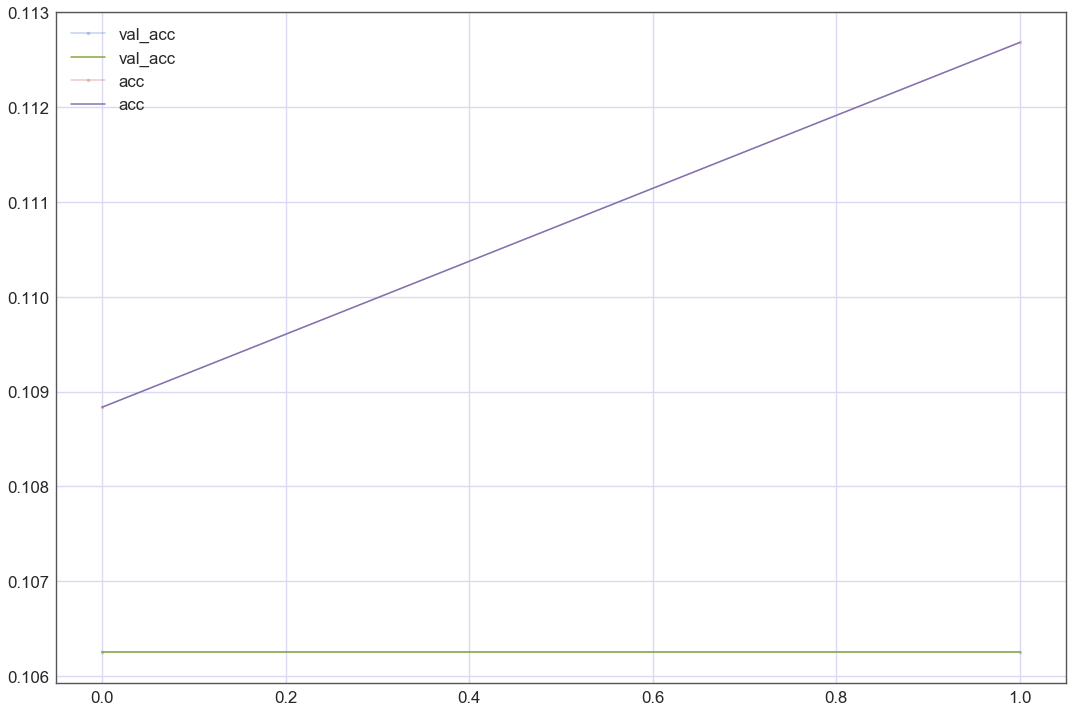

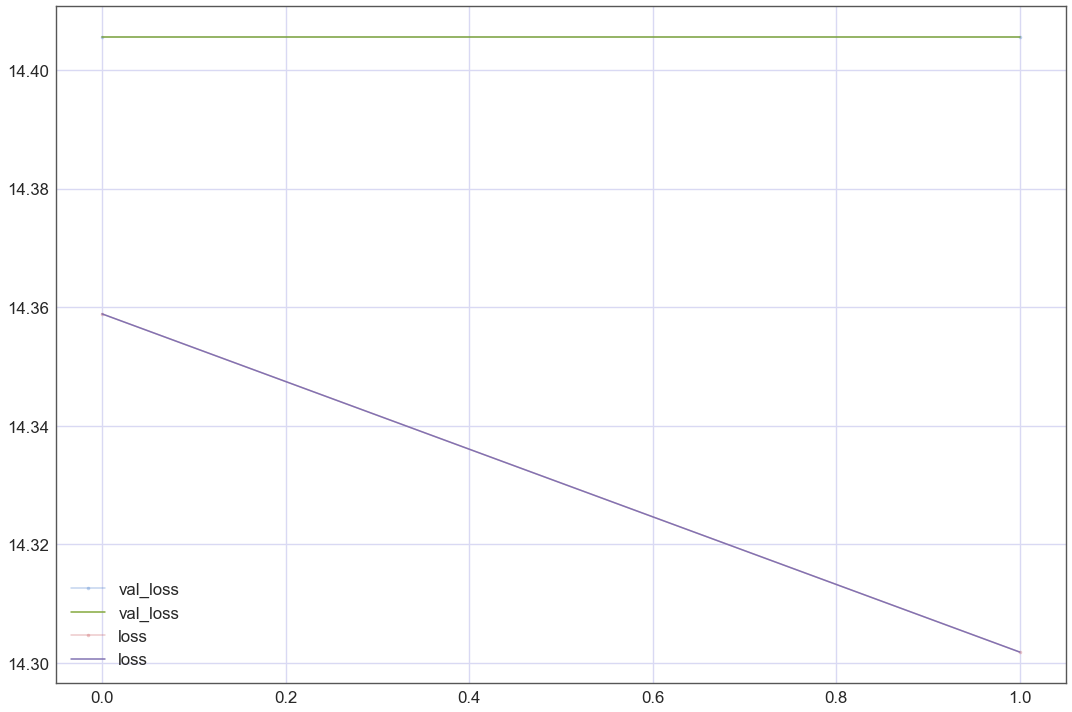

In [15]:
fit_model(2, save=False)

The model is no better than random. To investigate why this is, let's look at the weights.

Mean: 1.247572981810663e-06, Std: 0.0043483031913638115, Min: -0.01163950003683567, Max: 0.011639400385320187


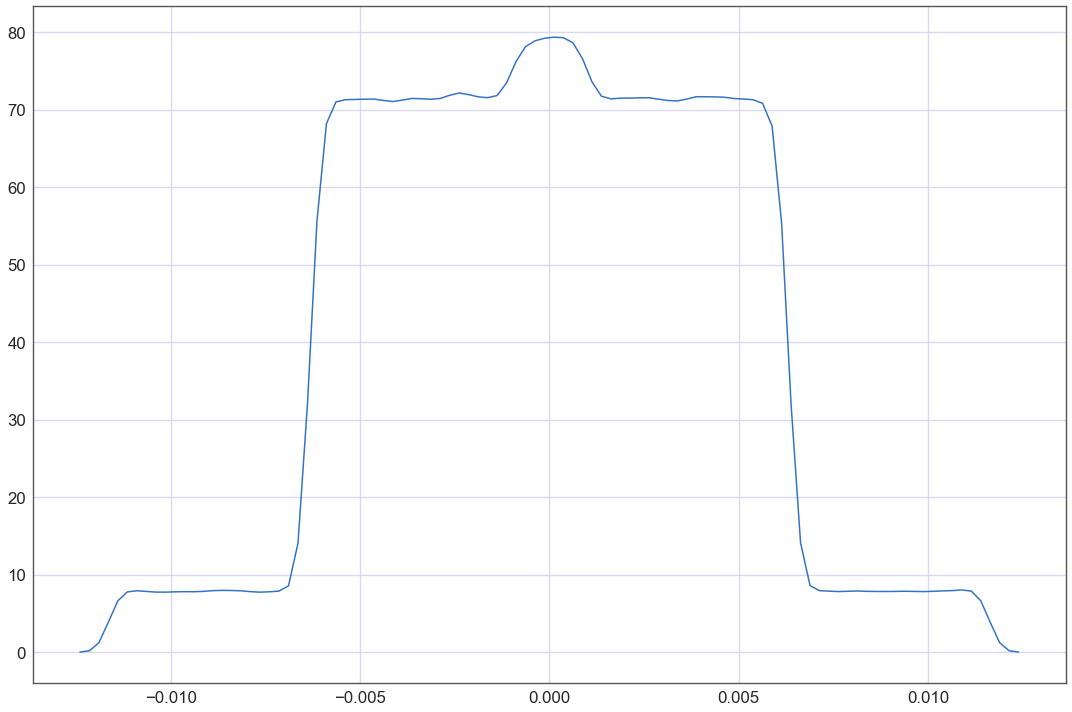

In [16]:
plot_weights()

Funny shape but seems to be okay. What about the actual predictions?

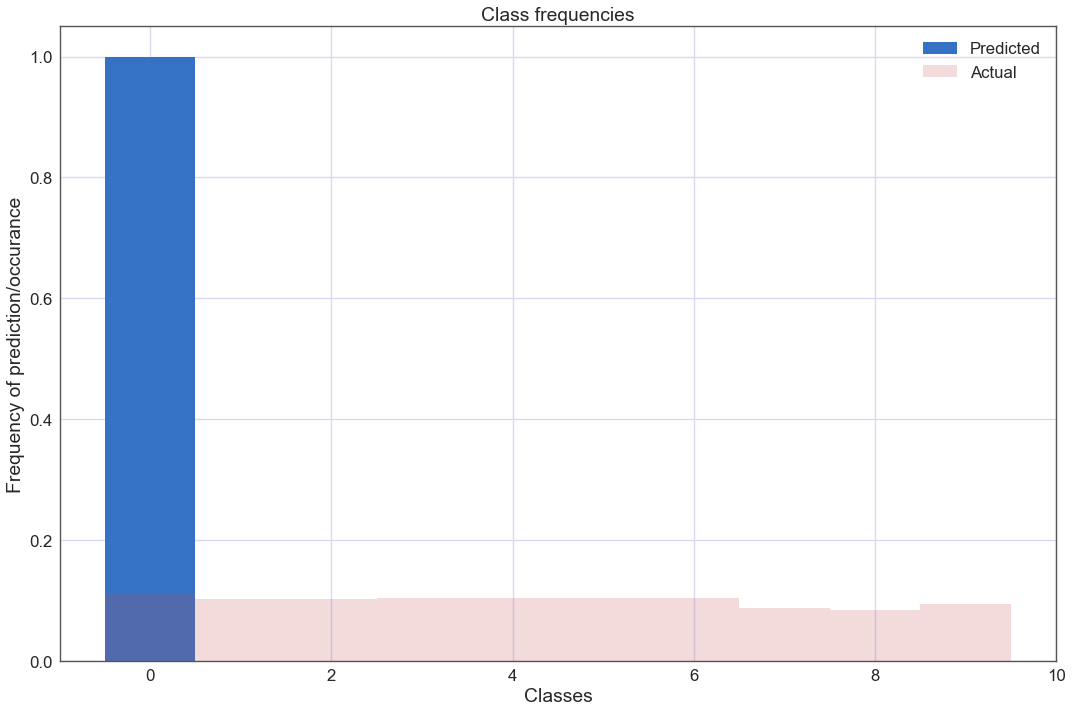

In [17]:
plot_prediction_density(model, train_batches)

Mode collapse!
The model predicts a single class/a few classes consistantly.

All is not well with the weights.

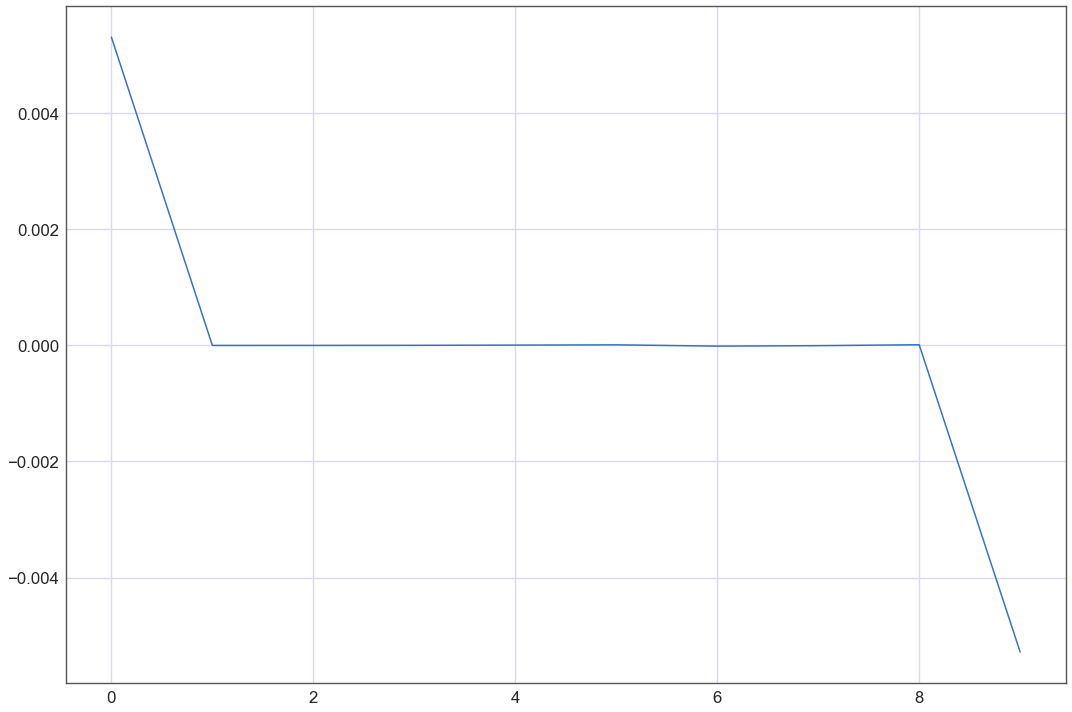

In [18]:
plot(model.layers[-1].get_weights()[0].mean(0))

The weights are high on average for a certain class. This predisposes the network towards predicting the particular class.

The reason might be that the network (weights) were knocked off too hard towards a certain direction.

The learning clearly saturates in the first epoch itself - suggesting that the **learning rate was too high.** The network could have seen more of that class on average early on.

Recovering from such a large hit off the ballpark (the neighbourhood of parameter space where the solution actually lies) is difficult.

So, let's start all over again. This time with a lower learning rate.

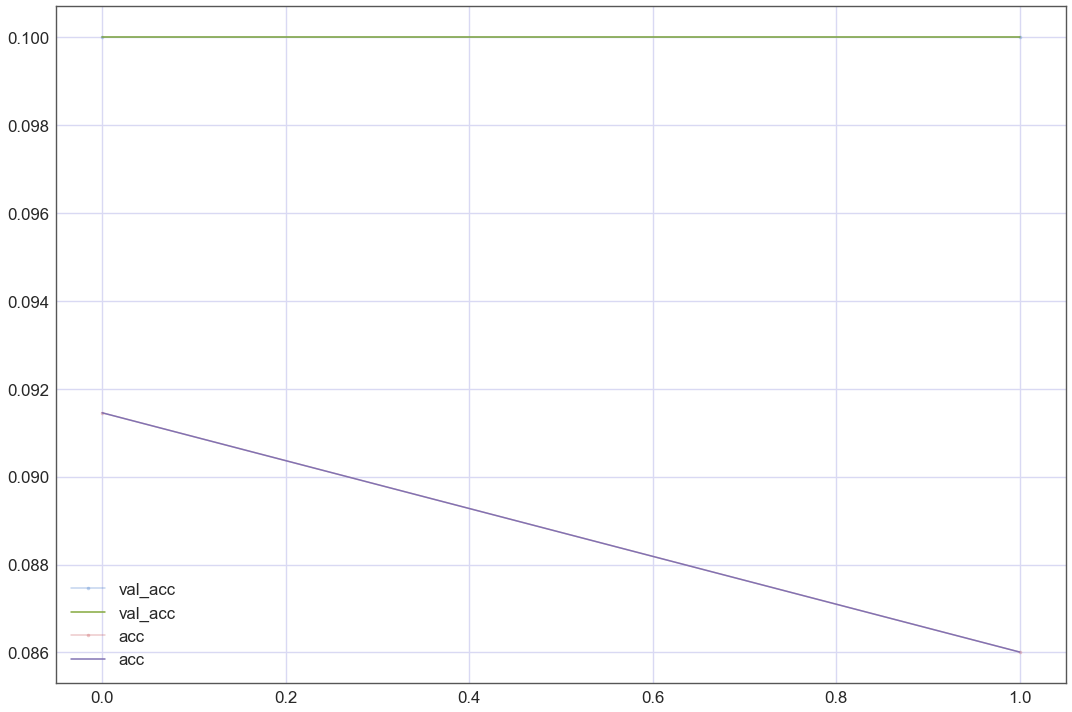

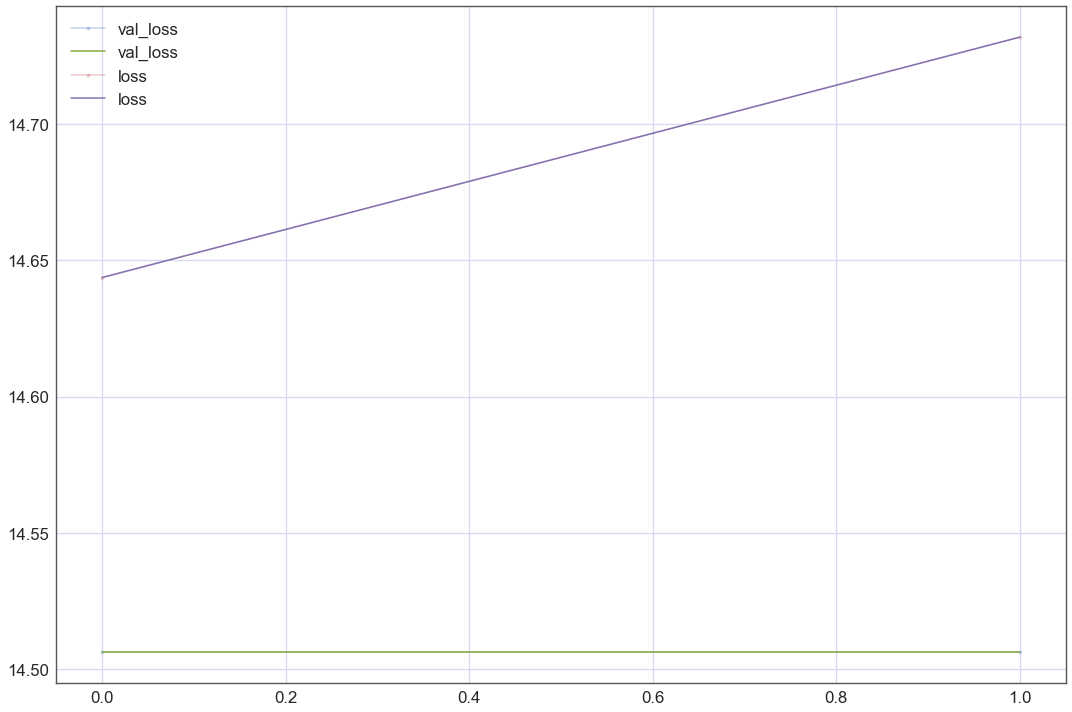

In [19]:
model = get_model()
fit_model(2, 1e-4, save=False)

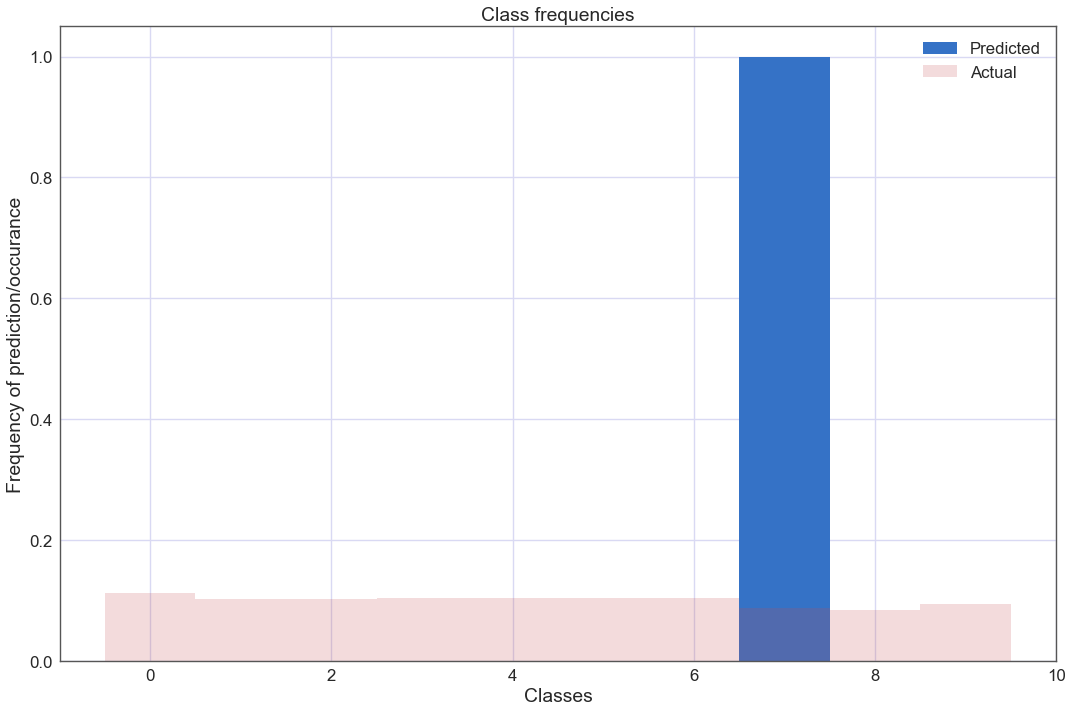

In [20]:
plot_prediction_density(model, train_batches)

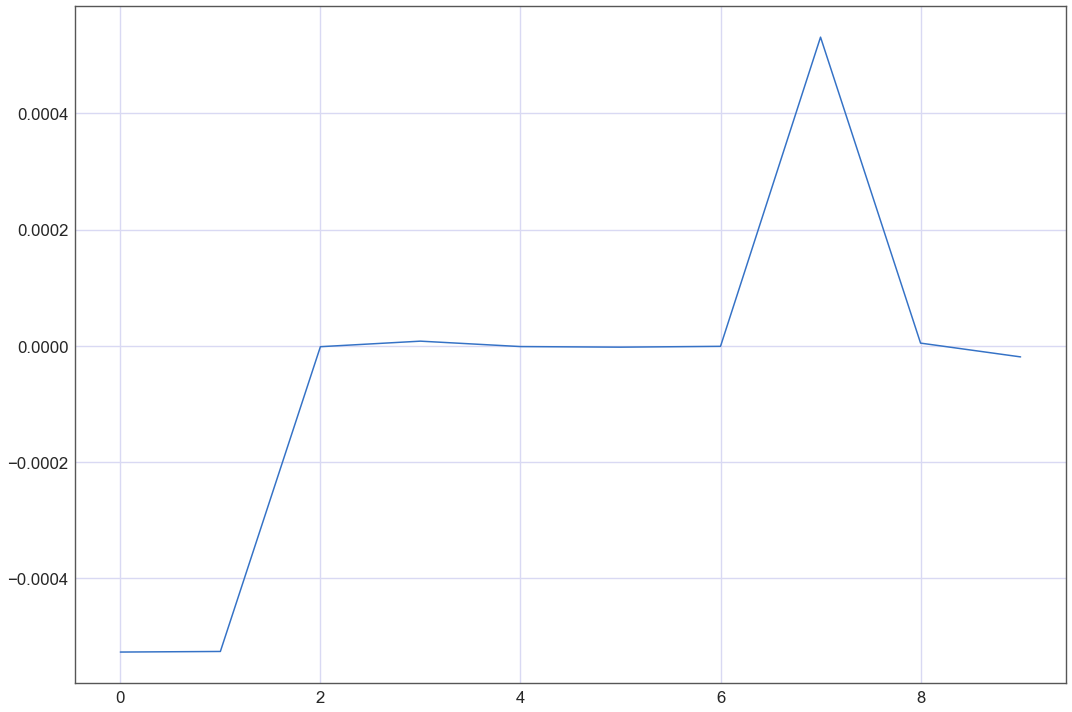

In [21]:
plot(model.layers[-1].get_weights()[0].mean(0))

No improvement once more ;(

Lower more!

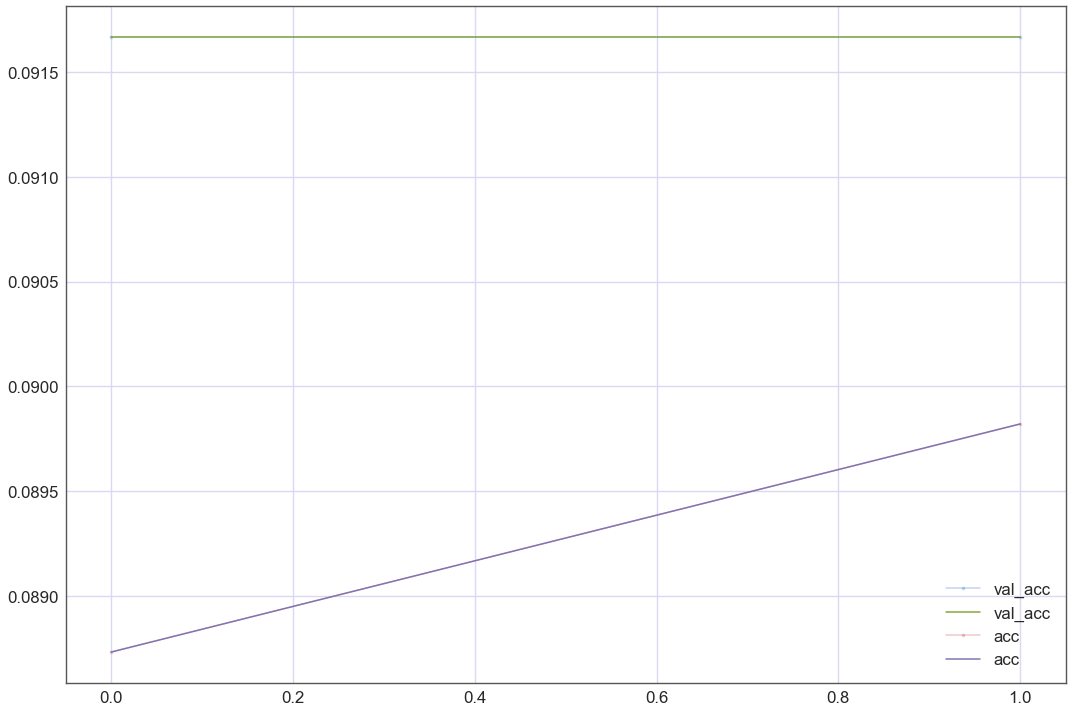

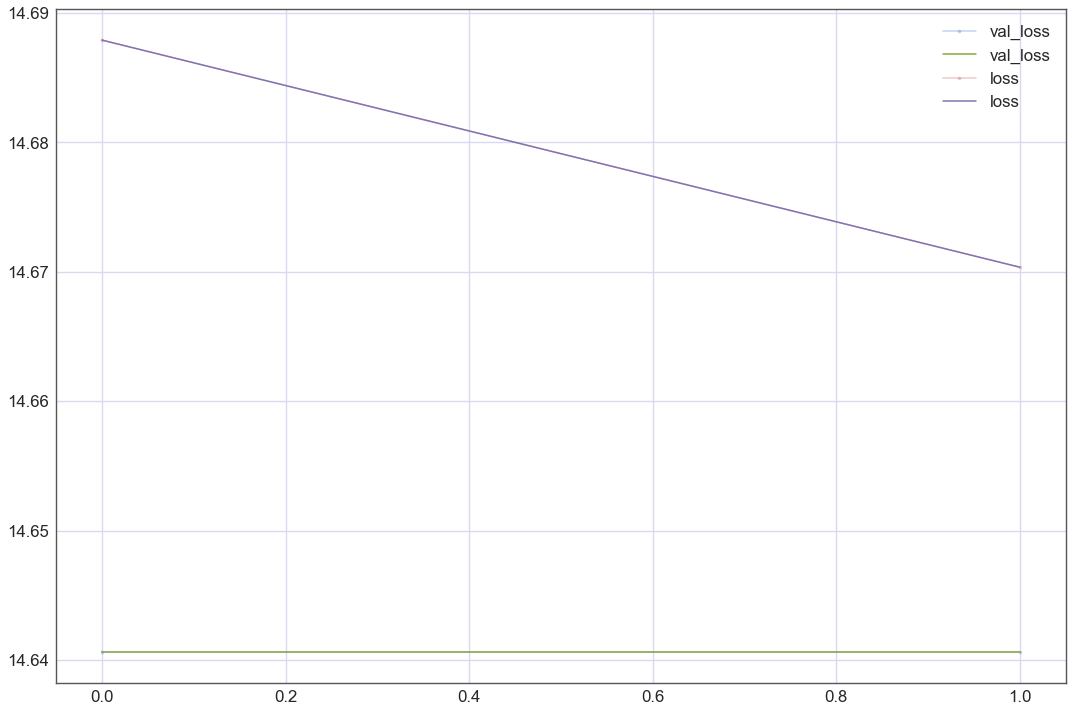

In [22]:
model = get_model()
fit_model(2, 1e-5, save=False)

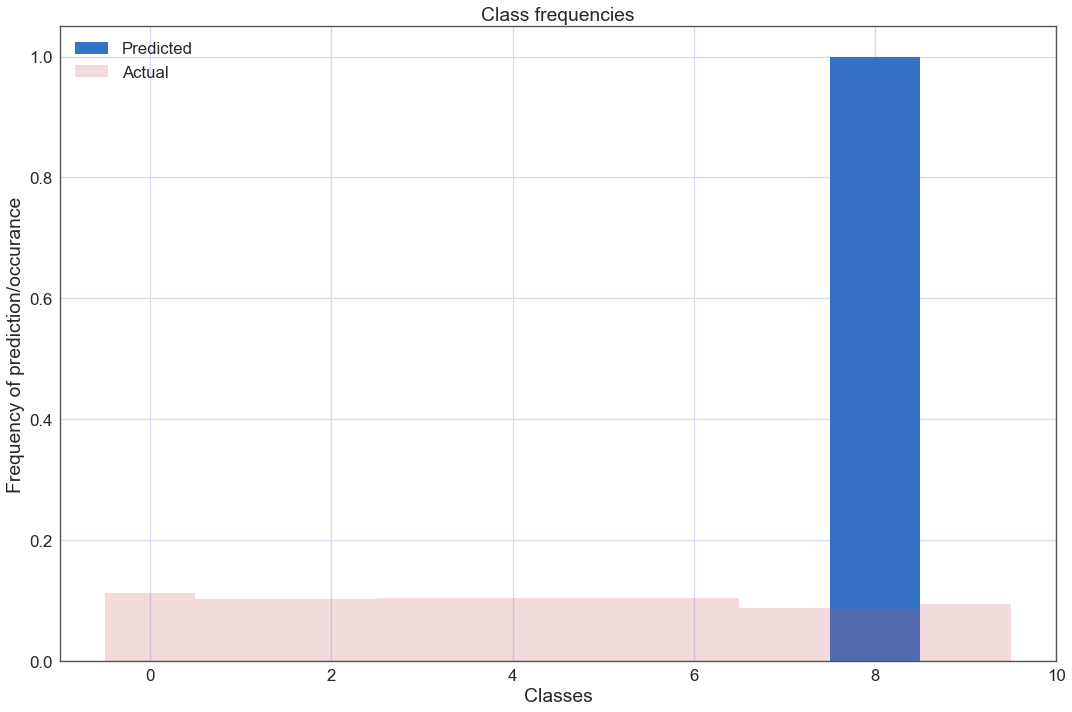

In [23]:
plot_prediction_density(model, train_batches)

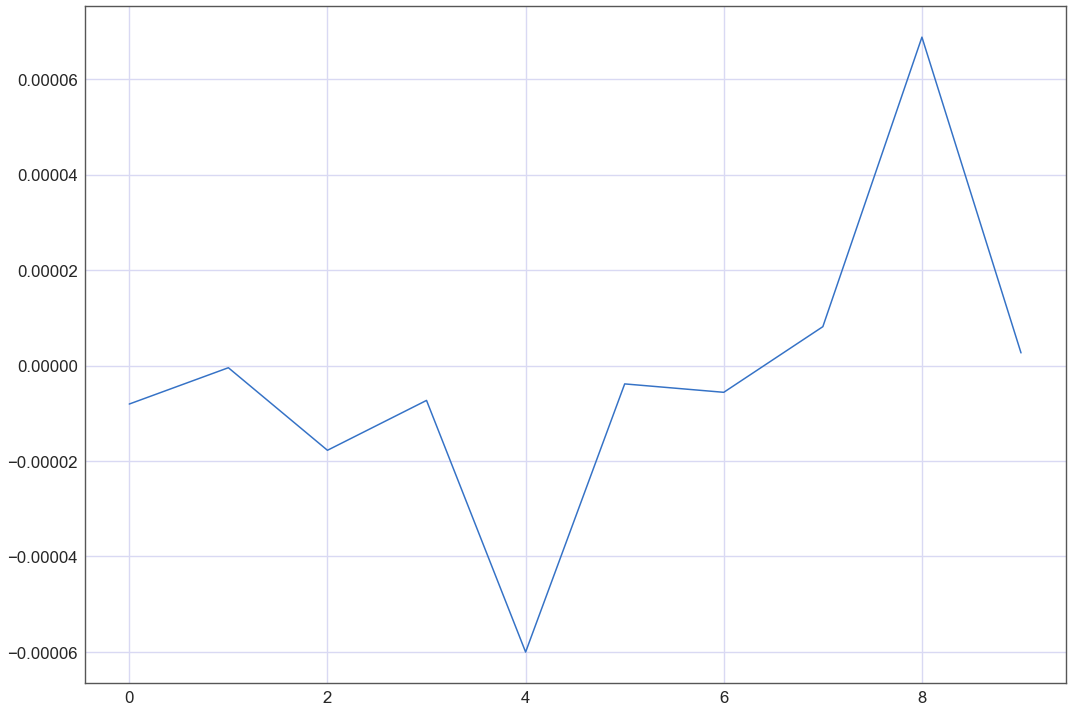

In [24]:
plot(model.layers[-1].get_weights()[0].mean(0))

Frustrated, we can try one thing - lower the learning rate more and fit more epochs

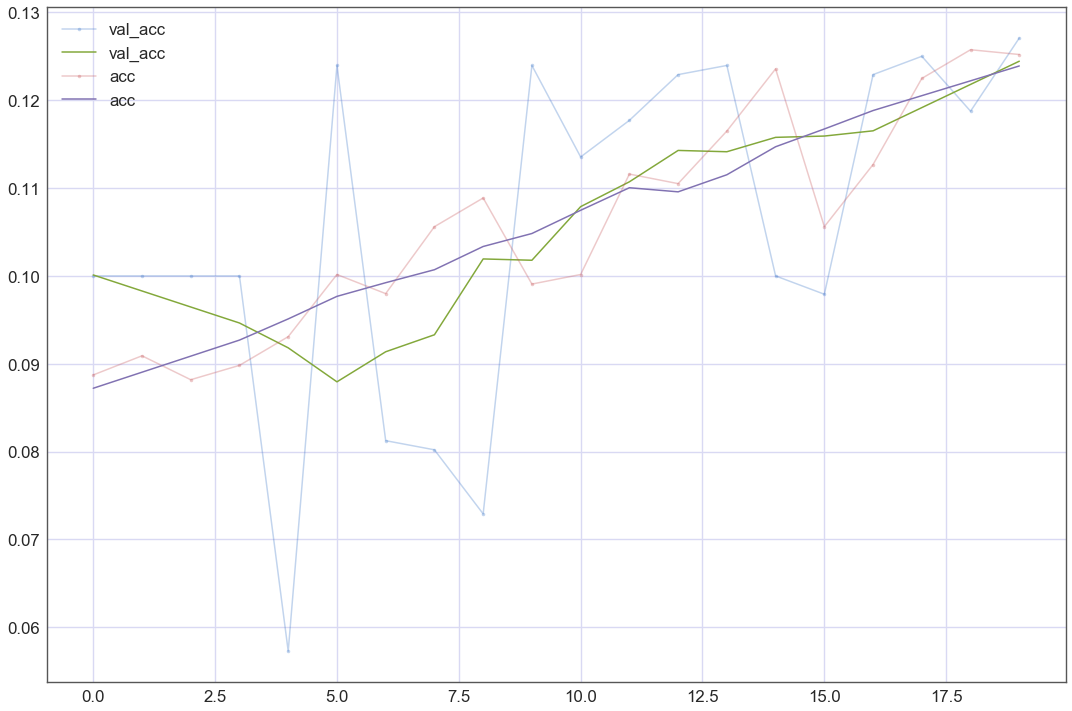

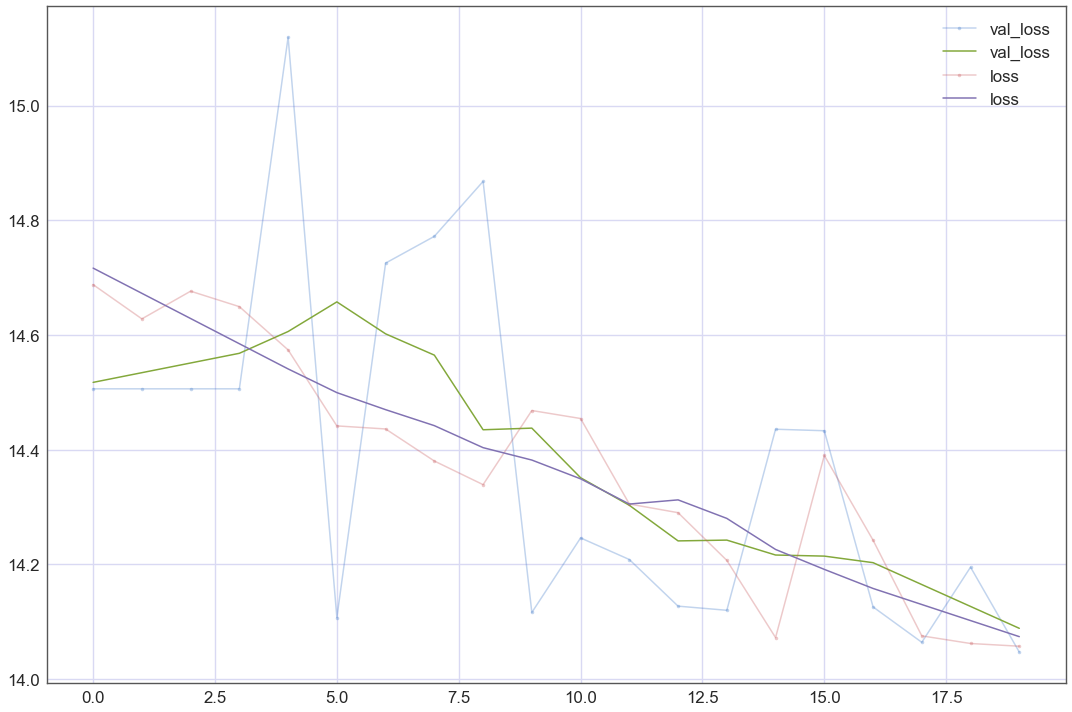

In [25]:
model = get_model()
fit_model(20, 1e-6, save=False)

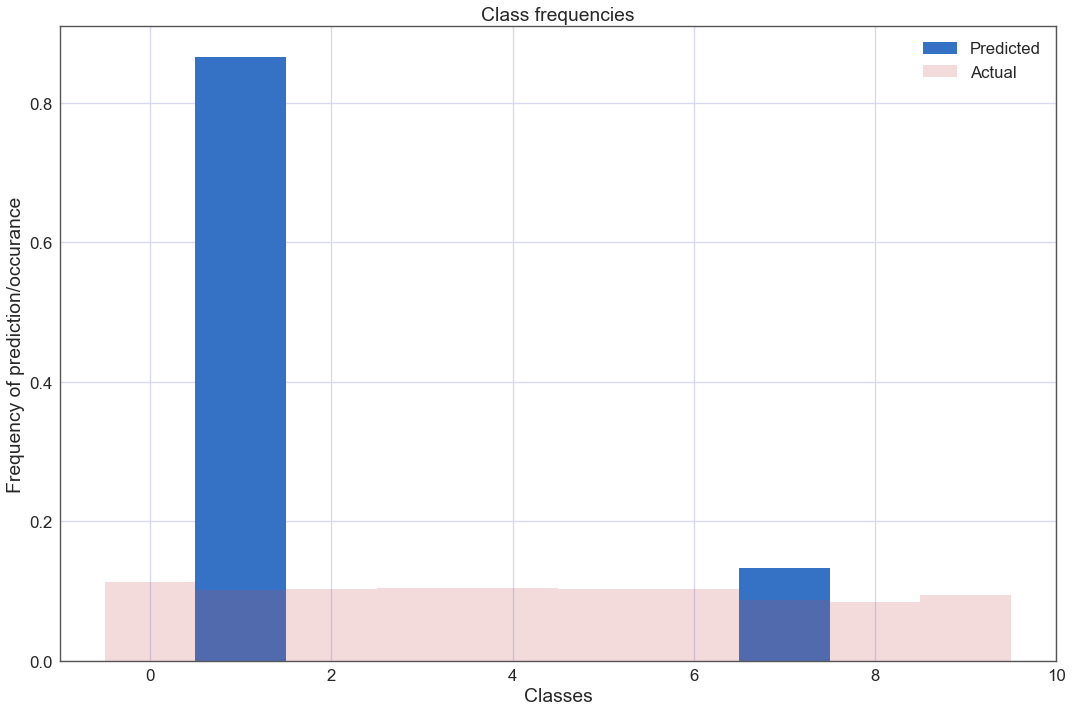

In [26]:
plot_prediction_density(model, train_batches)

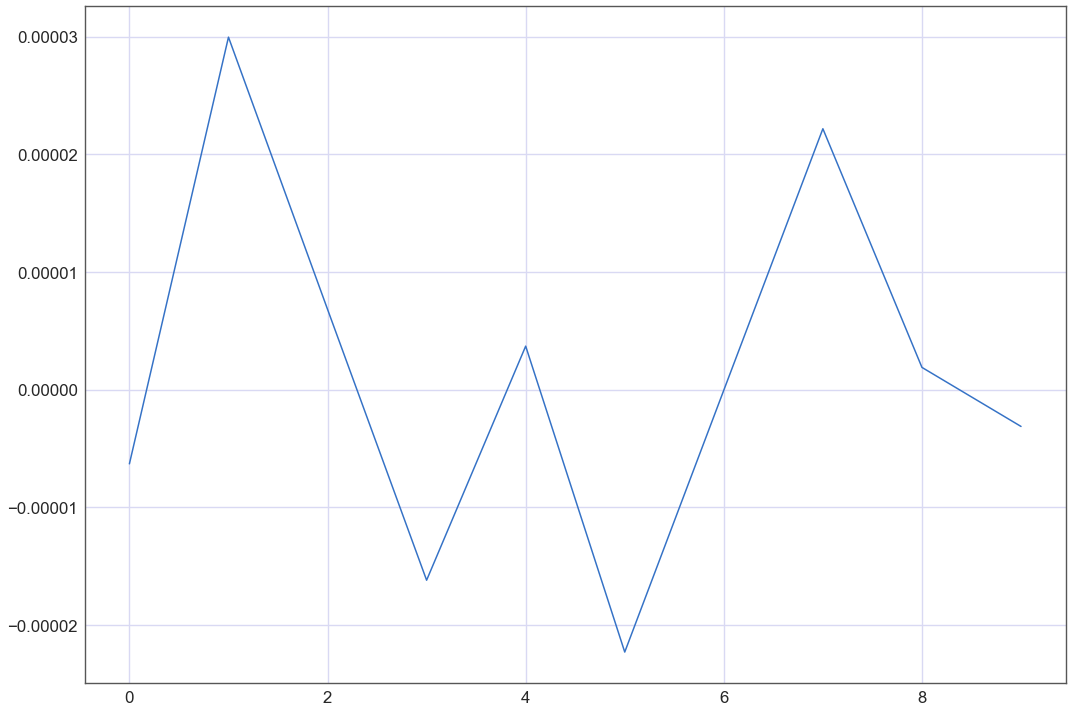

In [27]:
plot(model.layers[-1].get_weights()[0].mean(0))

Mean: 1.6569725858062156e-06, Std: 0.0036433872301131487, Min: -0.006432635243982077, Max: 0.006449112202972174


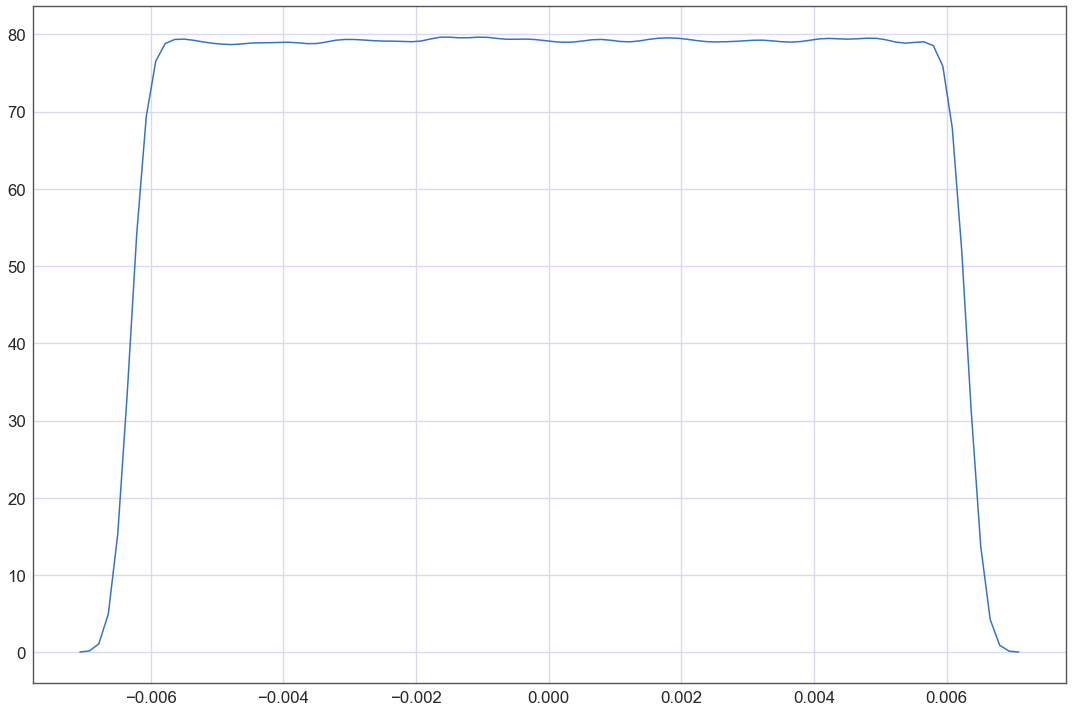

In [28]:
plot_weights()

What is wrong with it!

1. Is the model too simple?
2. Is the learning rate too high?
3. Is the model intrinsically unballanced?
4. Are we too stupid?

No. 4 can be ruled out _a priori_.

No. 2 is false since if we go further down, it doesn't make much sense to wait till eternity.

No. 1 is correct since it's the simplest model possible. But since we're not saturating (yet), we can rule it out. For all we know, we could be able to completely overfit the training data if we waited long enough.

No.3 is supported further by the fact that the mean weight is small and negative ~ `-1e-6`;
suggesting that _the input is large and positive_.

Alas! It is.

What a blunder!
We forgot to normalize the input images. They're still in the pixel range (0, 255).
Luckily, we don't need to do this by hand anymore. 

We have the magic of **BatchNormalization**

## Simple Linear Model

In [29]:
def get_model():
    K.clear_session()

    model = Sequential([BatchNormalization(input_shape=(224, 224, 3)),
                        Flatten(),
                        Dense(10, activation='softmax')])

    model.name = 'Simple-Linear'
    model.history = {}
    model.compile('adam', 'categorical_crossentropy', ['accuracy'])

    return model


model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1505290   
Total params: 1,505,302
Trainable params: 1,505,296
Non-trainable params: 6
_________________________________________________________________


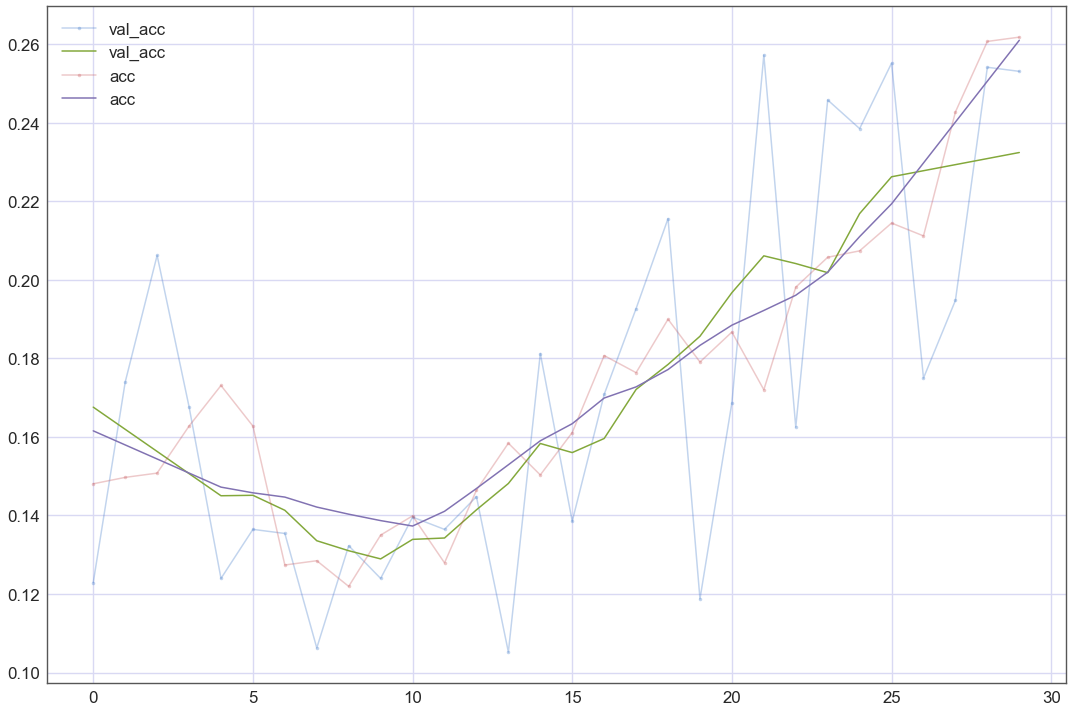

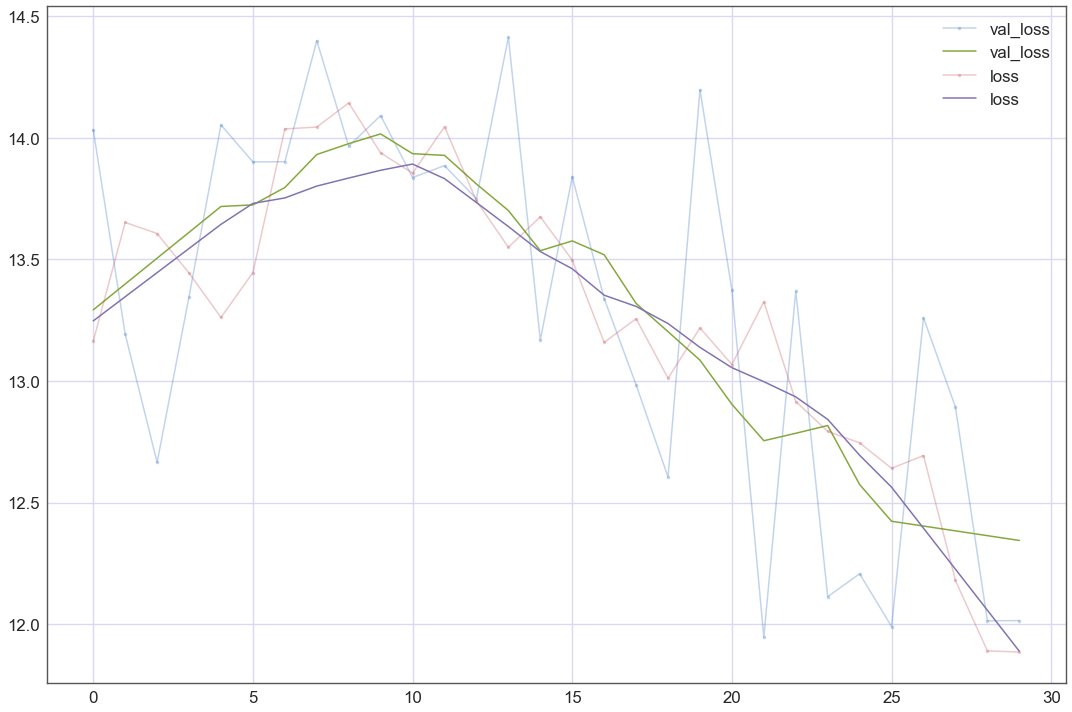

In [31]:
fit_model(30)
plot_history()

Not good! We took 30 epochs of training and peak at about 25% validation accuracy and asymptote at around 40% training accuracy at best.

Clearly, not good!

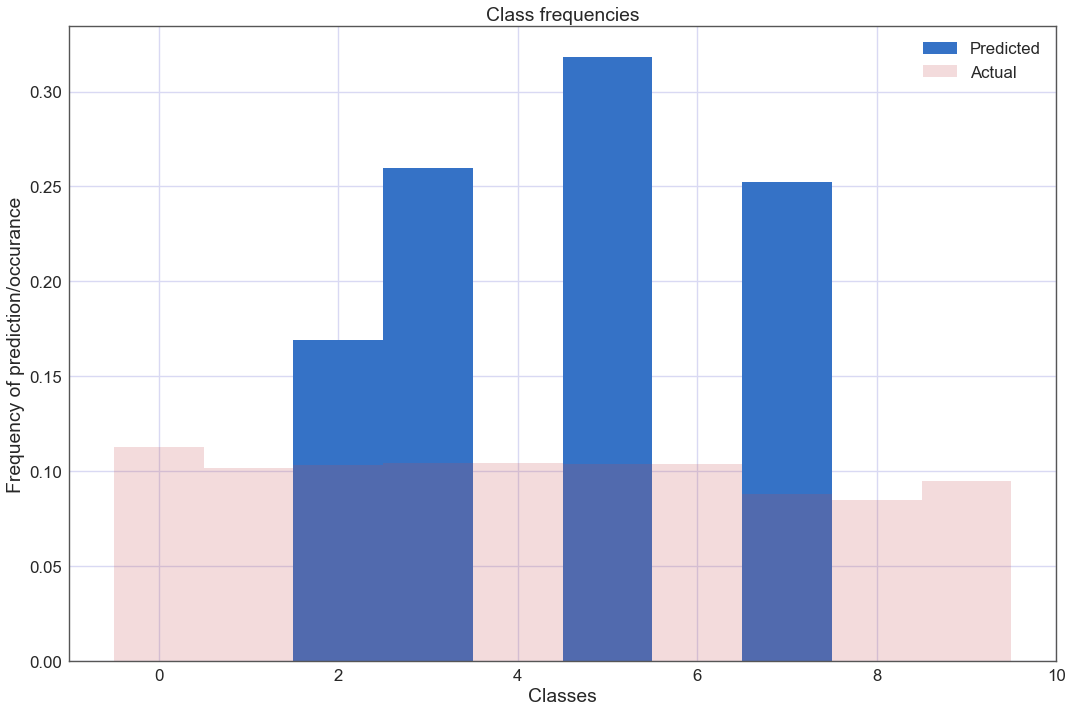

In [32]:
plot_prediction_density(model, train_batches)

The predictions are not uniform either. 

In this case, there's just one thing left to try -

Lower the learning rate!

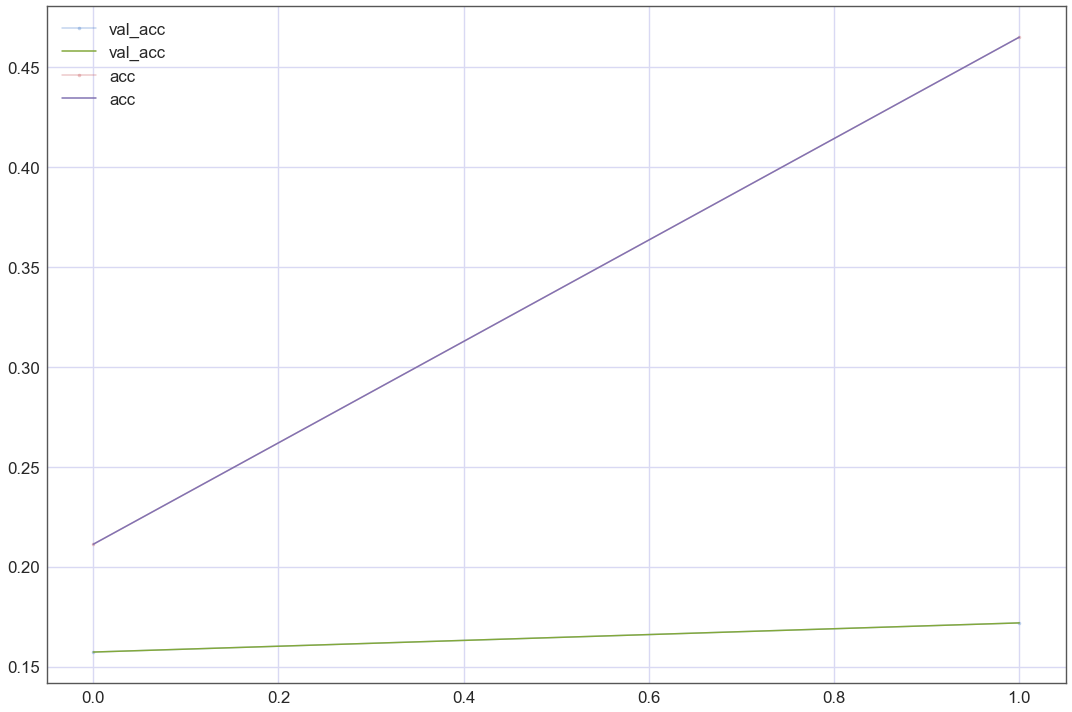

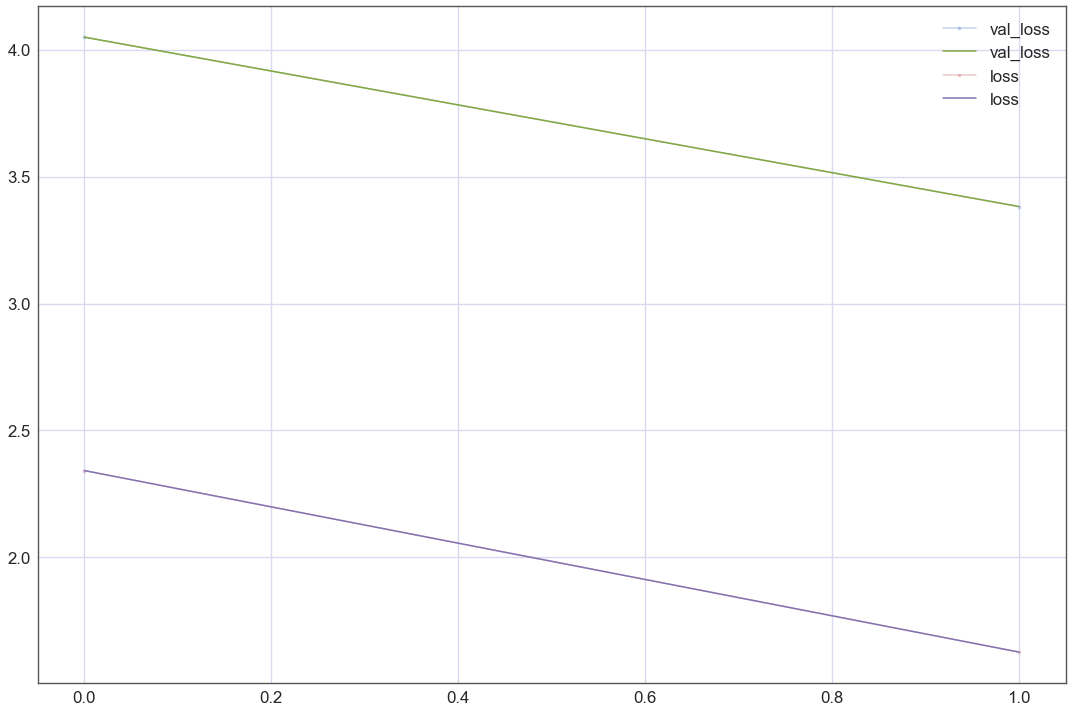

In [33]:
model = get_model()
fit_model( 2, 1e-5)

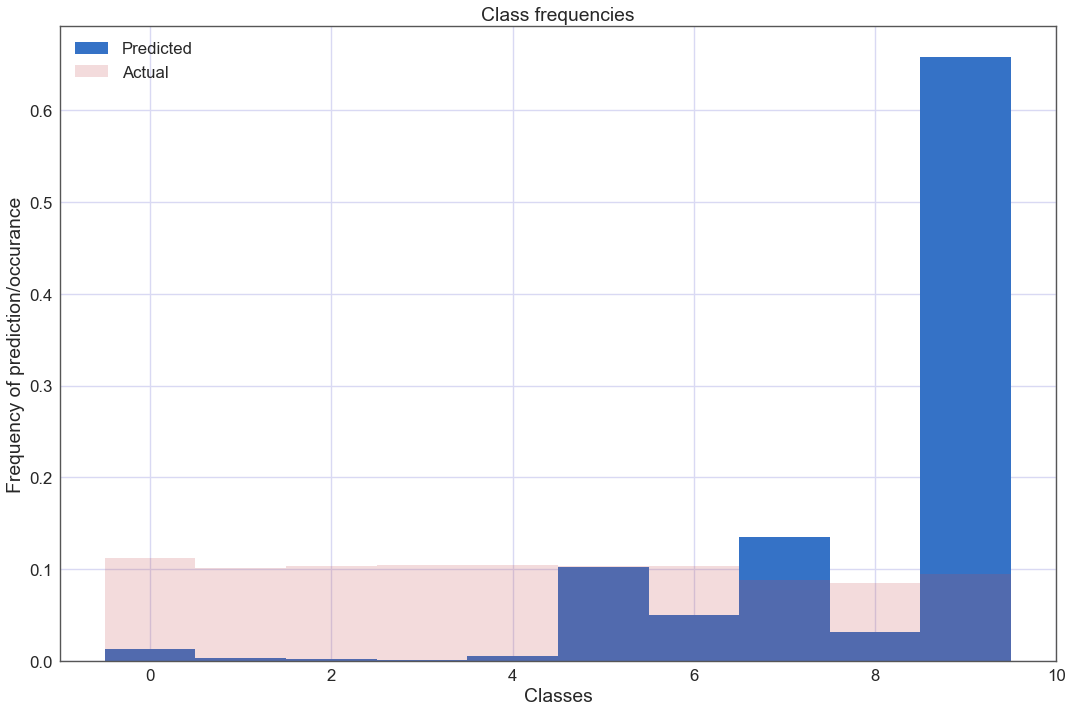

In [34]:
plot_prediction_density(model, train_batches)

Excellent. It seems that we are ready to increase the learning rate slightly now.

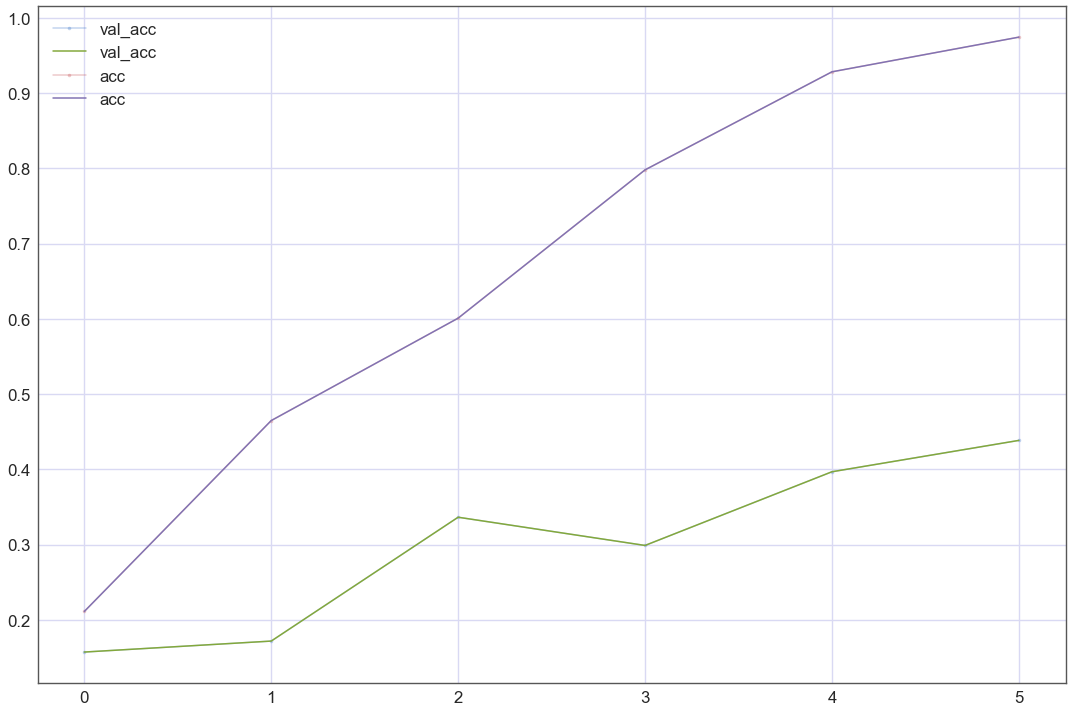

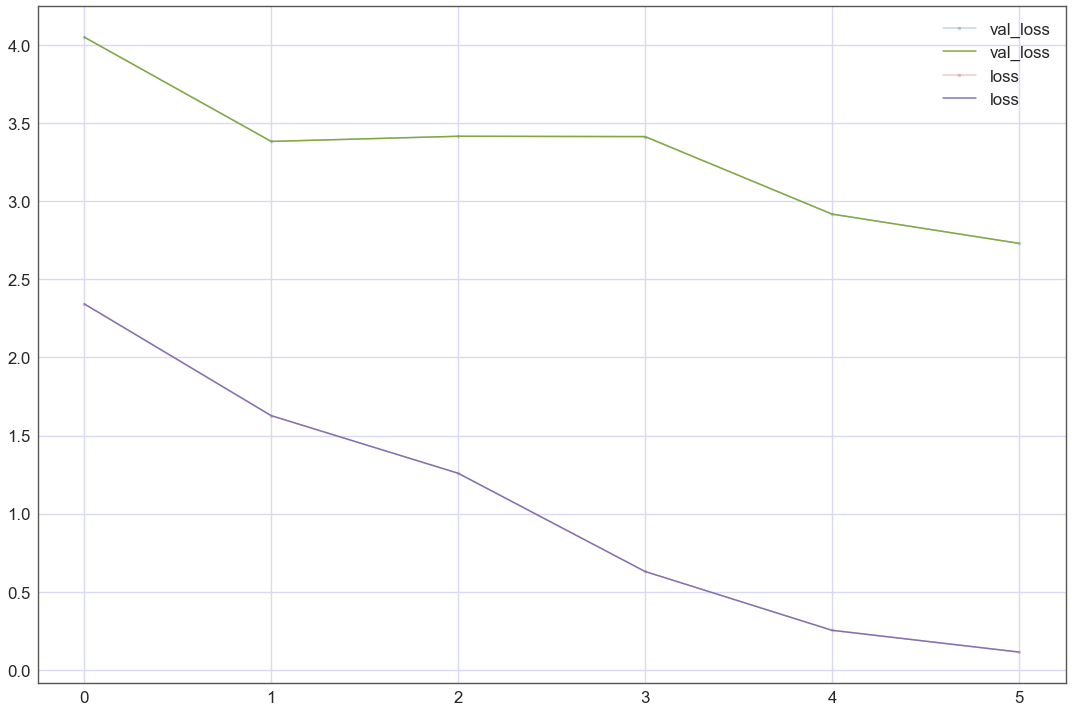

In [35]:
fit_model(4, 1e-4)

Check if the validation split is too low.

If the validation set is shuffled, and we see **~3%** variation in accuracy, the validation size needs to be increased (Why?)

Found 1004 images belonging to 10 classes.


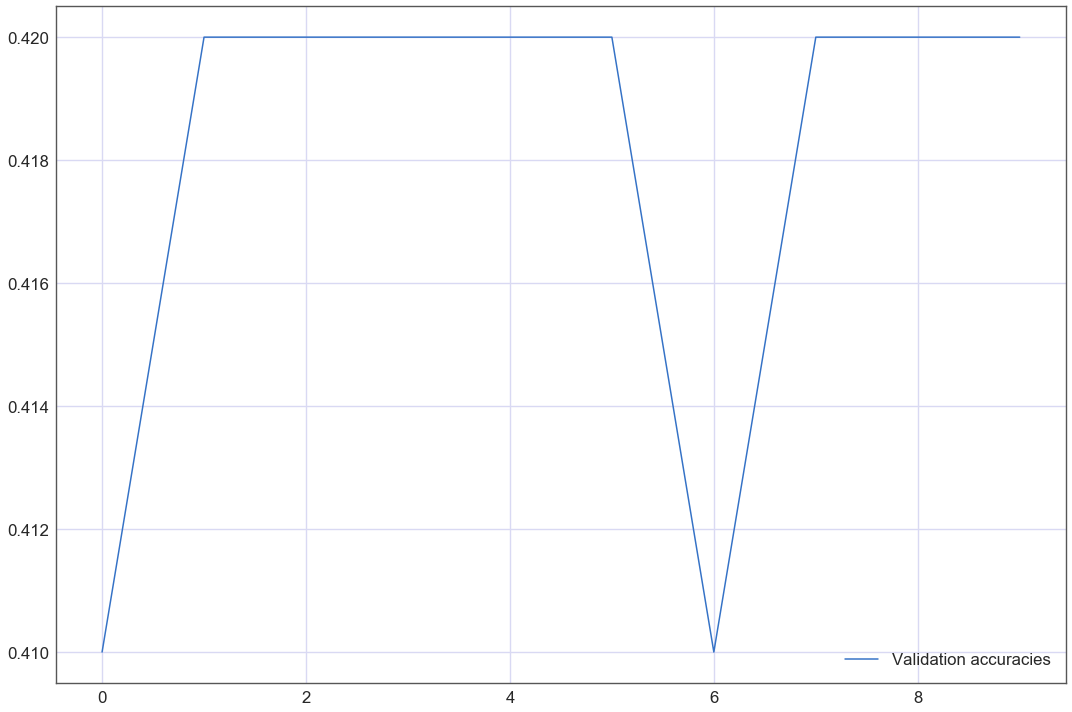

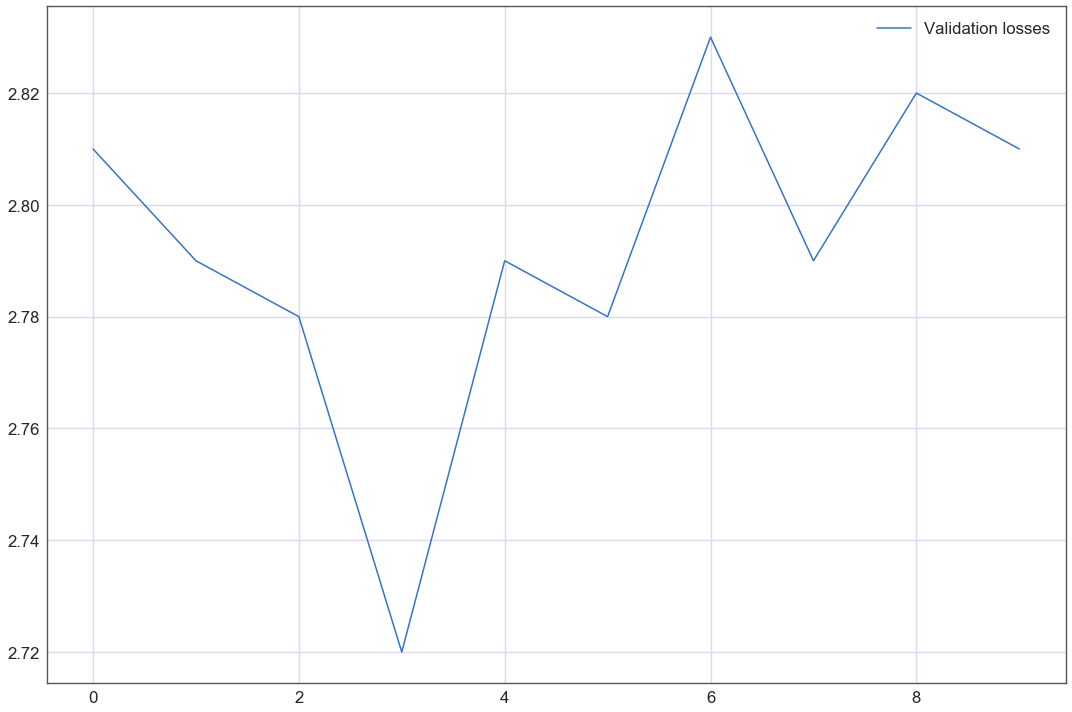

array([[ 2.81,  0.41],
       [ 2.79,  0.42],
       [ 2.78,  0.42],
       [ 2.72,  0.42],
       [ 2.79,  0.42],
       [ 2.78,  0.42],
       [ 2.83,  0.41],
       [ 2.79,  0.42],
       [ 2.82,  0.42],
       [ 2.81,  0.42]])

In [39]:
rand_valid_batches = get_batches(DIR_VALID, generator, 64)

rand_valid_results = np.round([model.evaluate_generator(
    rand_valid_batches, rand_valid_batches.num_batches) for _ in tqdm_notebook(range(10))], 2)

plot(rand_valid_results[:, 1], label='Validation accuracies')
plt.legend()
plt.show()
plot(rand_valid_results[:, 0], label='Validation losses')
plt.legend()
plt.show()
rand_valid_results

## L2 Regularization

In [42]:
def get_model(reg=0.01):
    K.clear_session()

    model = Sequential([BatchNormalization(input_shape=(224, 224, 3)),
                        Flatten(),
                        Dense(10, activation='softmax', kernel_regularizer=l2(reg))])

    model.name = 'Simple-Linear-L2'
    model.history = {}
    model.compile('adam', 'categorical_crossentropy', ['accuracy'])

    return model


model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1505290   
Total params: 1,505,302
Trainable params: 1,505,296
Non-trainable params: 6
_________________________________________________________________


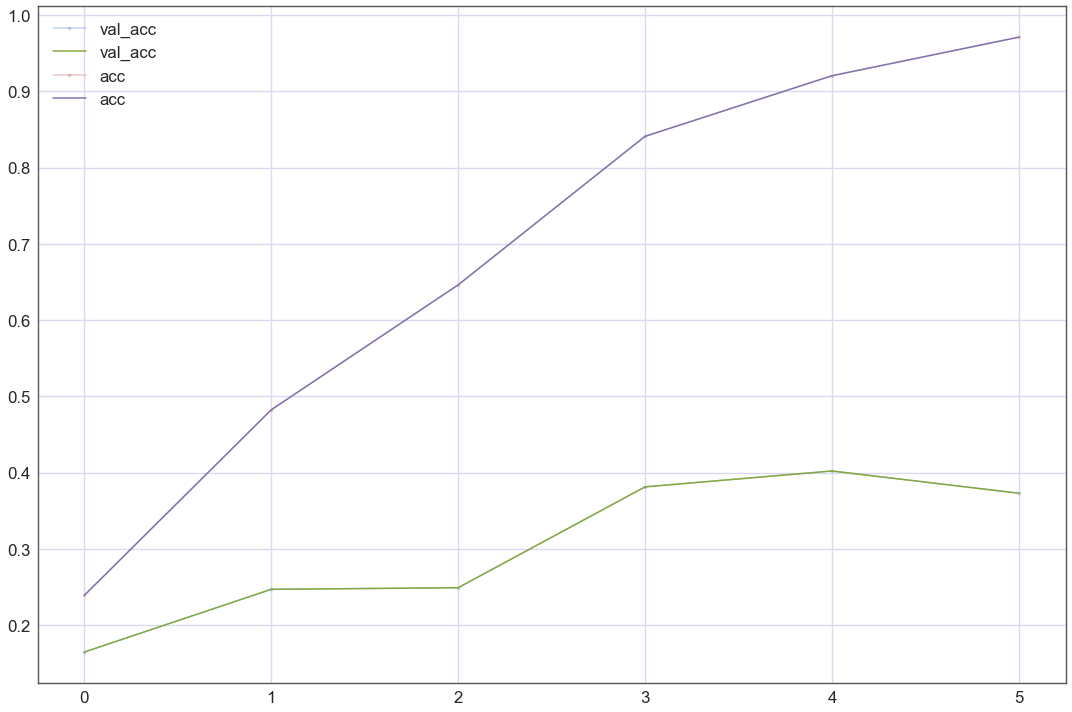

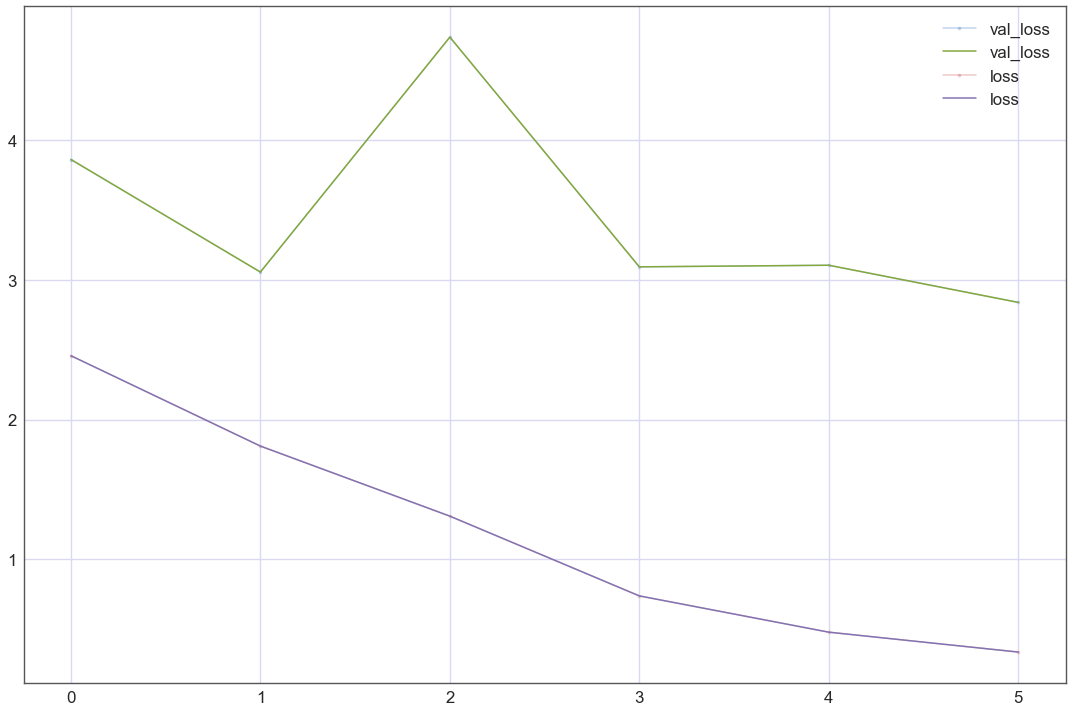

In [43]:
fit_model([2, 4], [1e-5, 1e-4])

Clearly, this is not working. 

Perhaps the regularization is too small.

Let's ramp it up

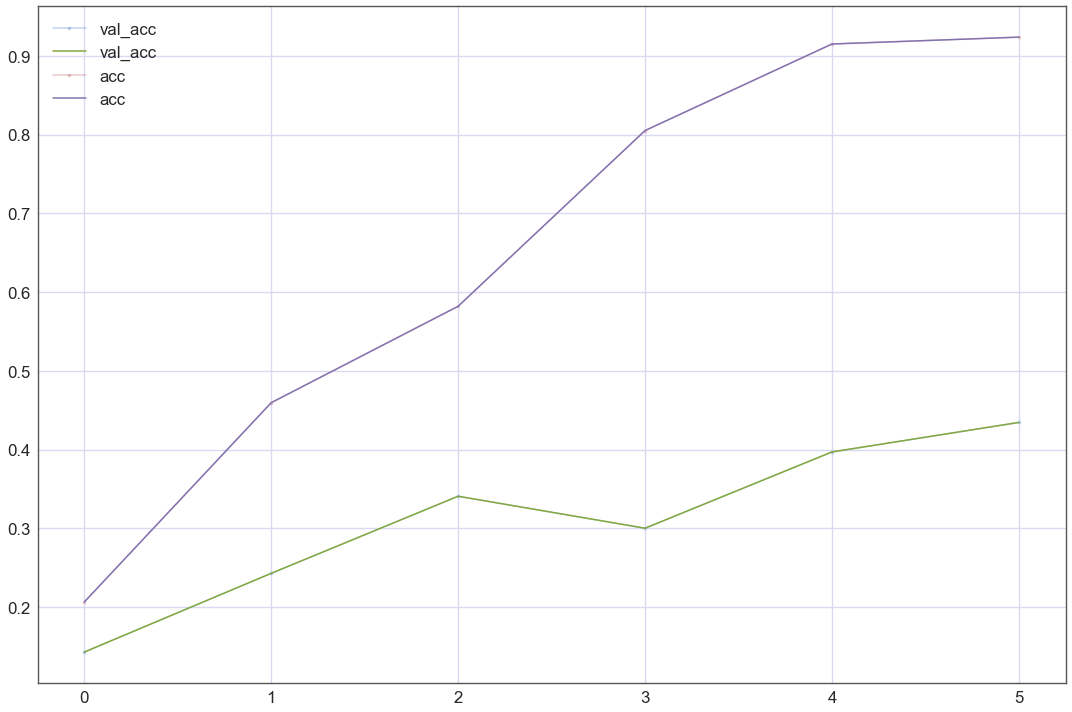

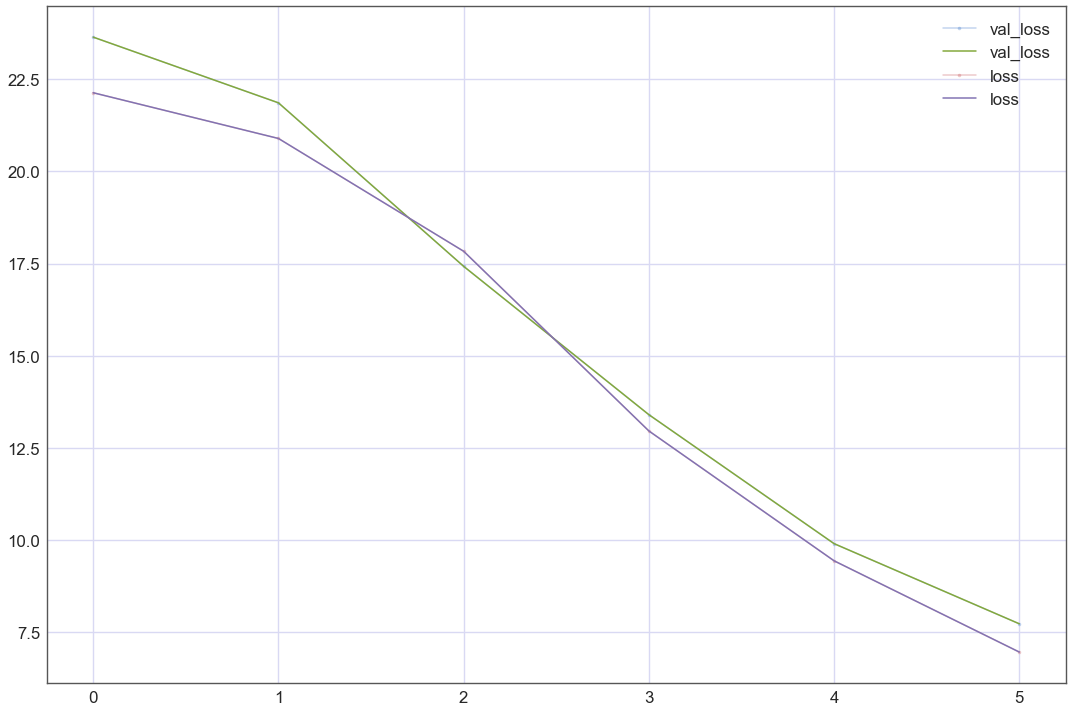

In [44]:
model = get_model(reg=1)
fit_model([2, 4], [1e-5, 1e-4])

Aside: The accuracy metrics are almost the same. But why does the loss scale up?

Still not enough.

Go higher! 

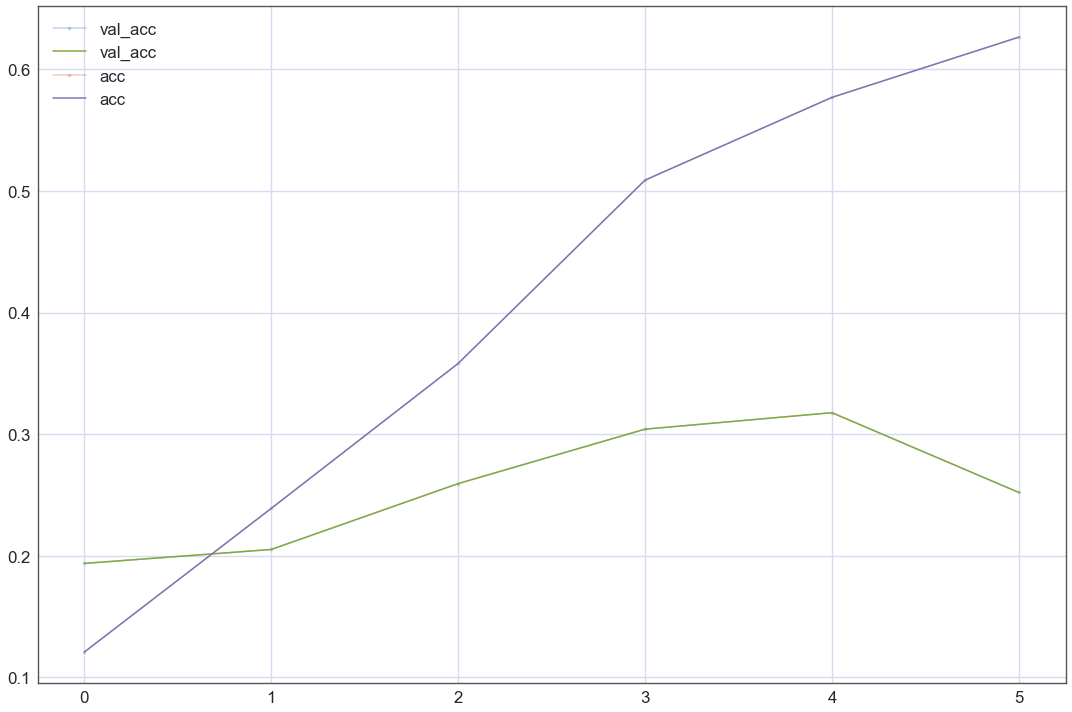

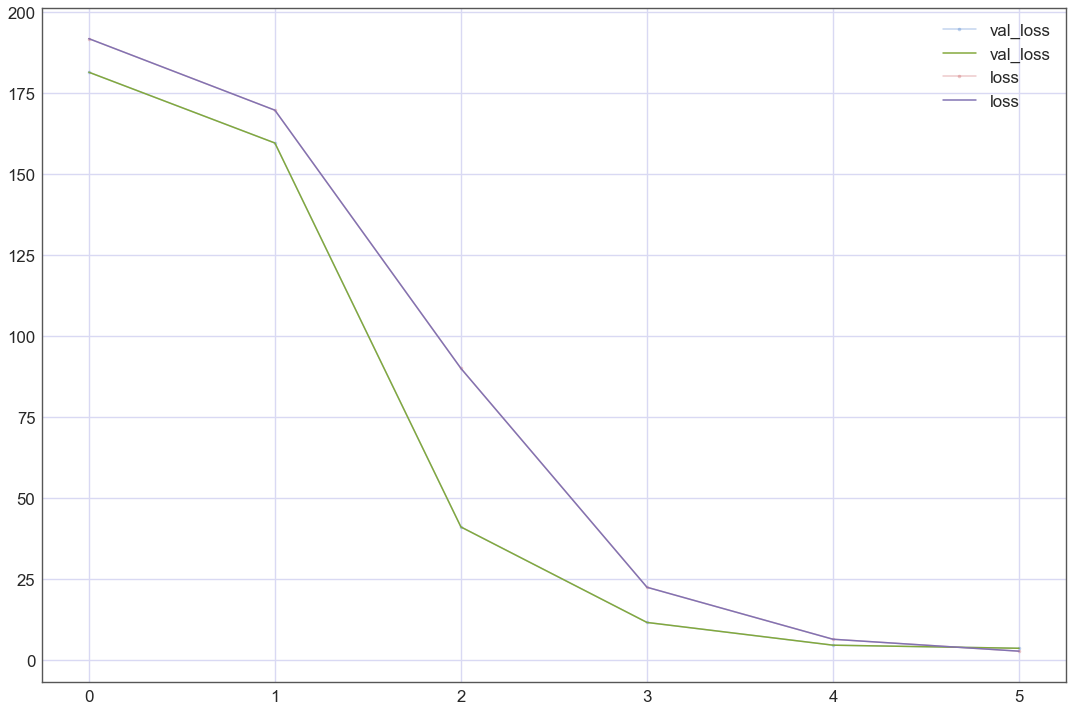

In [45]:
model = get_model(reg=10)
fit_model([2, 4], [1e-5, 1e-4])

Shows promise. Let's continue training

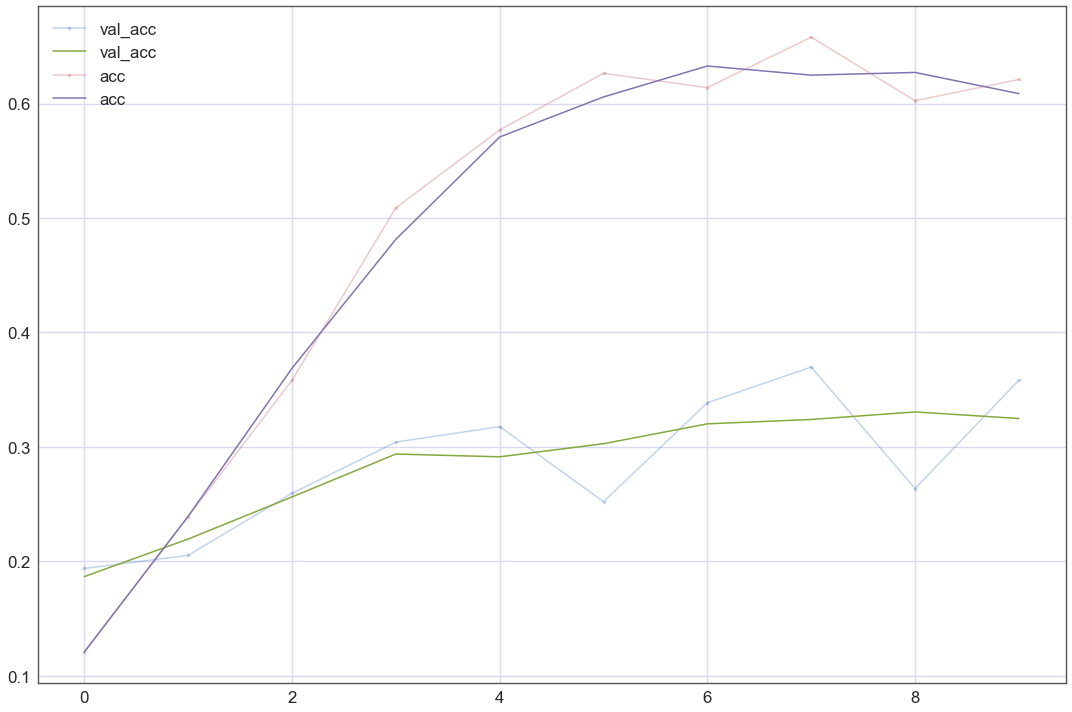

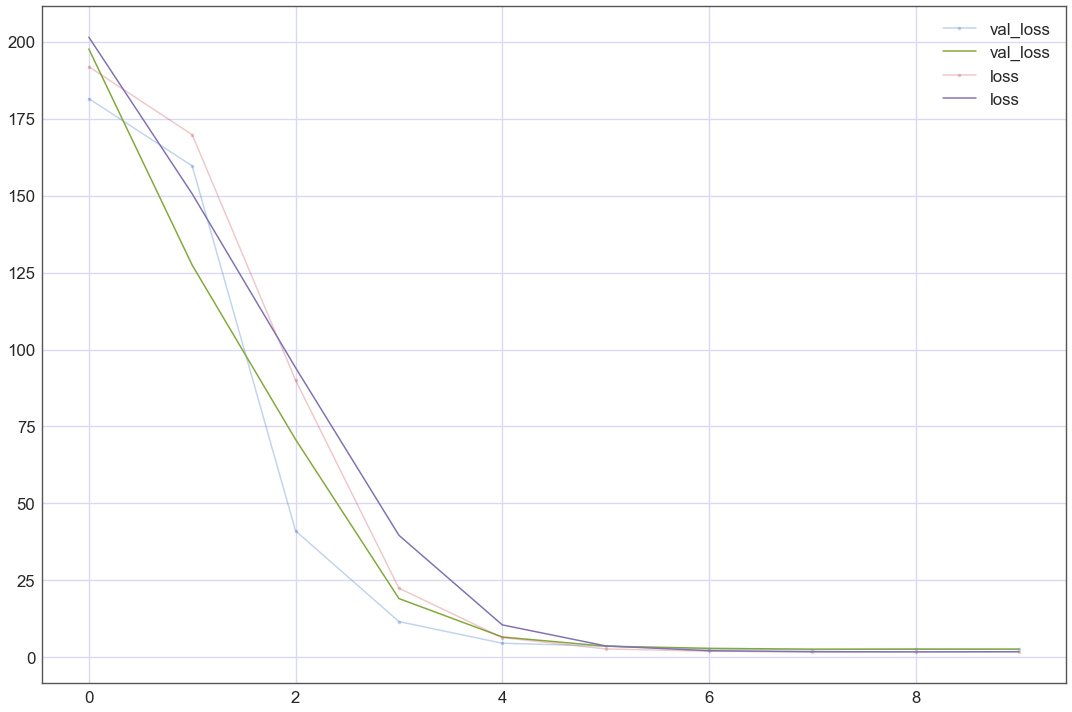

In [46]:
fit_model(4)

Well, that doesn't help.

Regularization clearly has little to no effect here.

We can't use Dropout because we can't tune it since it's related to data specifics (we're using a sample here - size matters! Why?)

Data Augmentation it is!

# Data Augmentation

To find the best parameters, we'll use our best linear model and evaluate the final validation accuracy.

In [ ]:
def get_model():
    clear_session()

    model = Sequential([BatchNormalization(input_shape=(224, 224, 3)),
                        Flatten(),
                        Dense(10, activation='softmax')])

    model.name = 'Simple-Linear'
    model.history = {}
    model.compile('adam', 'categorical_crossentropy', ['accuracy'])

    return model


model = get_model()
model.summary()

In [ ]:
def plot_augmented_samples(parameter_name, parameter_range, num_points=10):
    if type(parameter_range) != tuple and type(parameter_range) != list:
        parameter_range = (0, parameter_range)

    for param_value in tqdm_notebook(np.linspace(parameter_range[0], parameter_range[1], num_points)):
        generator_augmented = ImageDataGenerator()
        setattr(generator_augmented, parameter_name, param_value)
        train_batches = get_batches(DIR_TRAIN, generator_augmented, 64)
        plot_images(iter(train_batches).next()[0][:9], param_value)

In [ ]:
def get_augmented_acc(parameter_name, parameter_range, num_points=10):
    if type(parameter_range) != tuple and type(parameter_range) != list:
        parameter_range = (0, parameter_range)

    val_acc = {}
    for param_value in tqdm_notebook(np.linspace(parameter_range[0], parameter_range[1], num_points)):
        model = get_model()
        generator_augmented = ImageDataGenerator()
        setattr(generator_augmented, parameter_name, param_value)
        train_batches = get_batches(DIR_TRAIN, generator=generator_augmented)

        fit_model(model, [2, 4], [1e-5, 1e-4], verbose=False)
        val_acc[param_value] = model.history['val_acc'][-1]
    plot(list(val_acc.keys()), list(val_acc.values()))
    print("Best {} = {}".format(parameter_name,
                                sorted(val_acc, key=val_acc.get)[-1]))
    return val_acc

## Width Shift Range

In [ ]:
plot_augmented_samples('width_shift_range', 1)

In [ ]:
augmented_val_acc = get_augmented_acc('width_shift_range', 0.3)

## Height Shift Range

In [ ]:
plot_augmented_samples('height_shift_range', 1)

In [ ]:
augmented_val_acc = get_augmented_acc('height_shift_range', 0.3)

# Try Various Models

## Create Training Set

In [15]:
generator_augmented = ImageDataGenerator(rotation_range=15, width_shift_range=0.1,
                                         height_shift_range=0.05, shear_range=0.1,
                                         channel_shift_range=20)
train_batches = get_batches(DIR_TRAIN, generator_augmented, 64)

Found 1901 images belonging to 10 classes.


## Simple Linear Model

In [49]:
def get_model():
    K.clear_session()

    model = Sequential([BatchNormalization(input_shape=(224, 224, 3)),
                        Flatten(),
                        Dense(10, activation='softmax')])

    model.name = 'Simple-Linear'
    model.history = {}
    model.compile('adam', 'categorical_crossentropy', ['accuracy'])

    return model


model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1505290   
Total params: 1,505,302
Trainable params: 1,505,296
Non-trainable params: 6
_________________________________________________________________


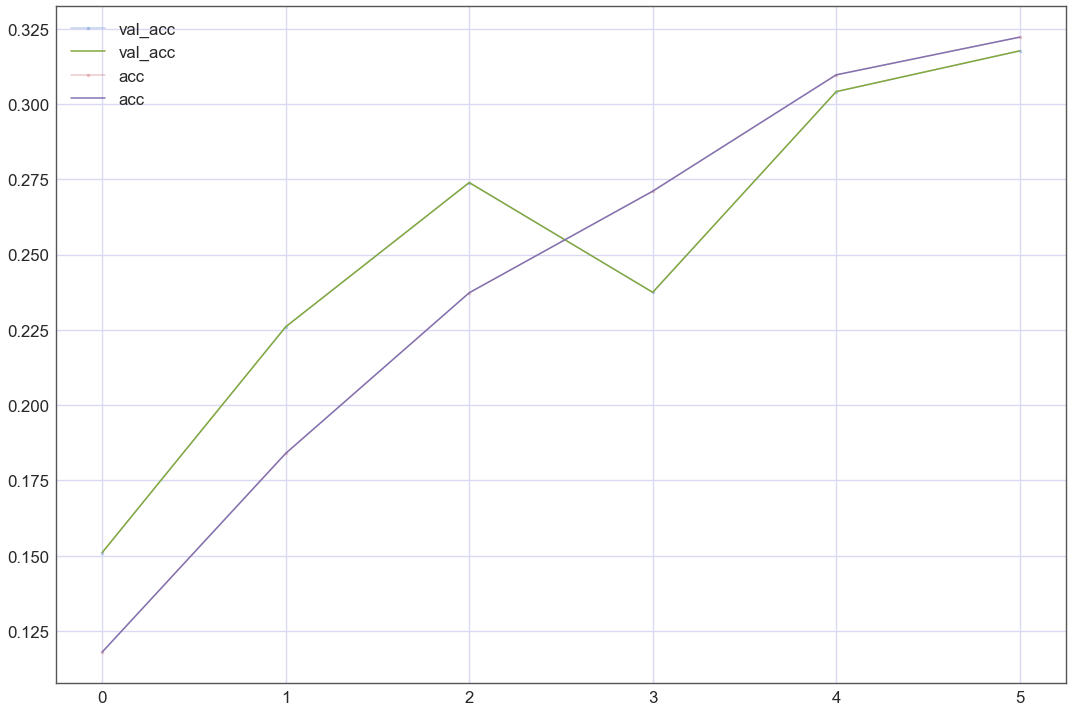

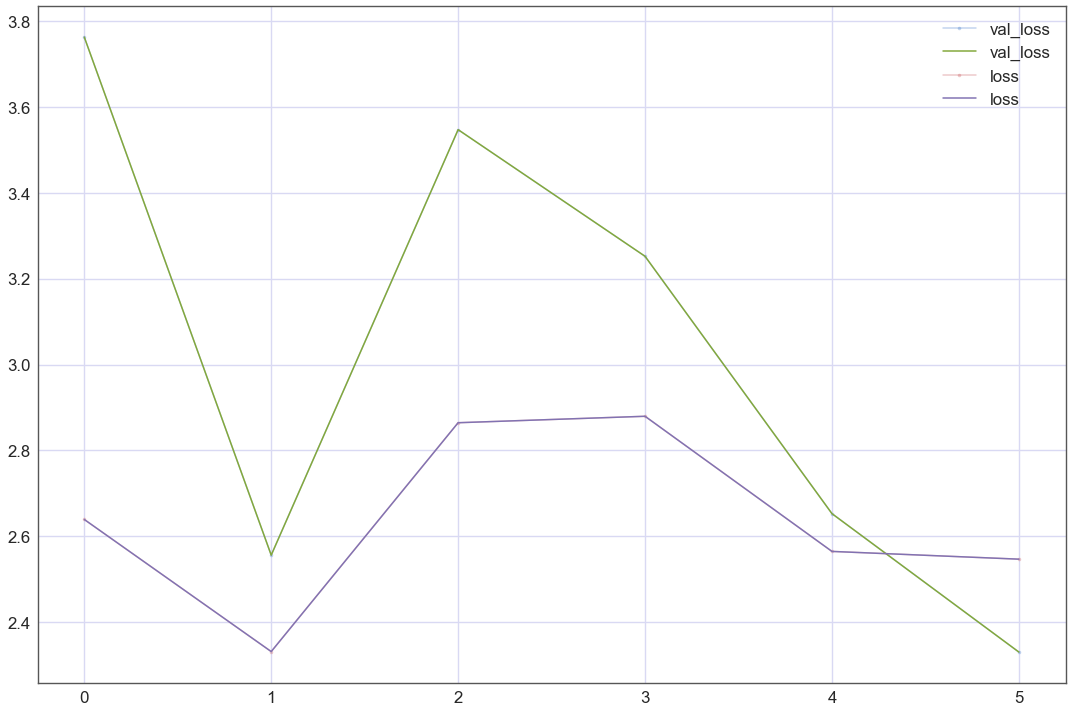

In [50]:
fit_model([2, 4], [1e-5, 1e-4])

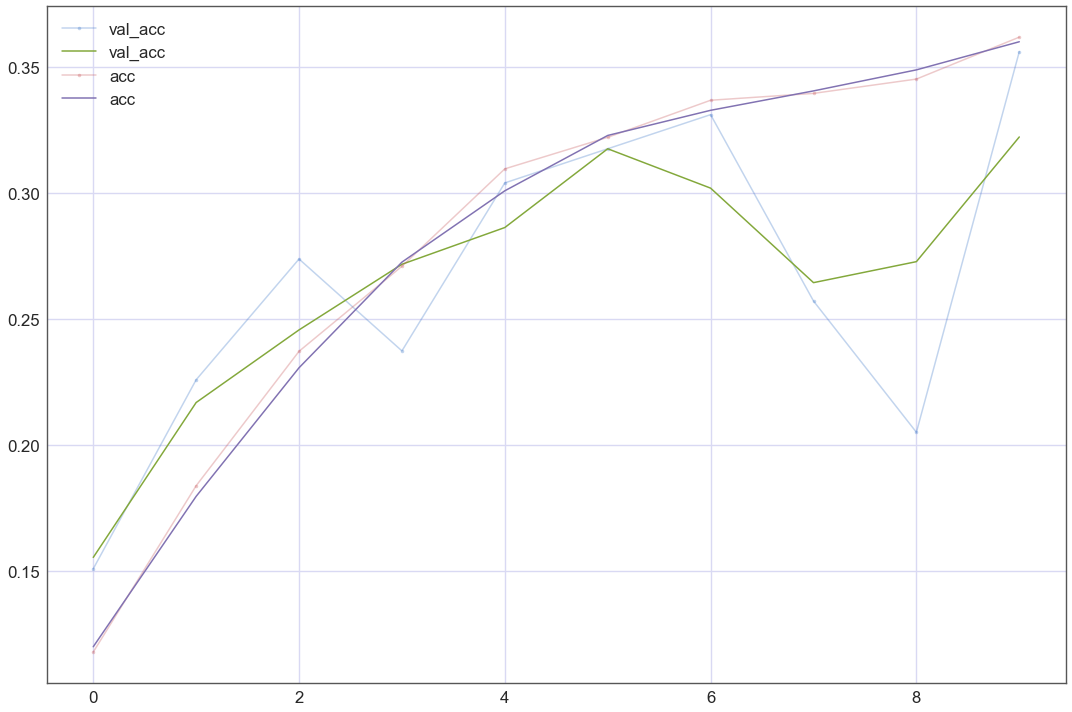

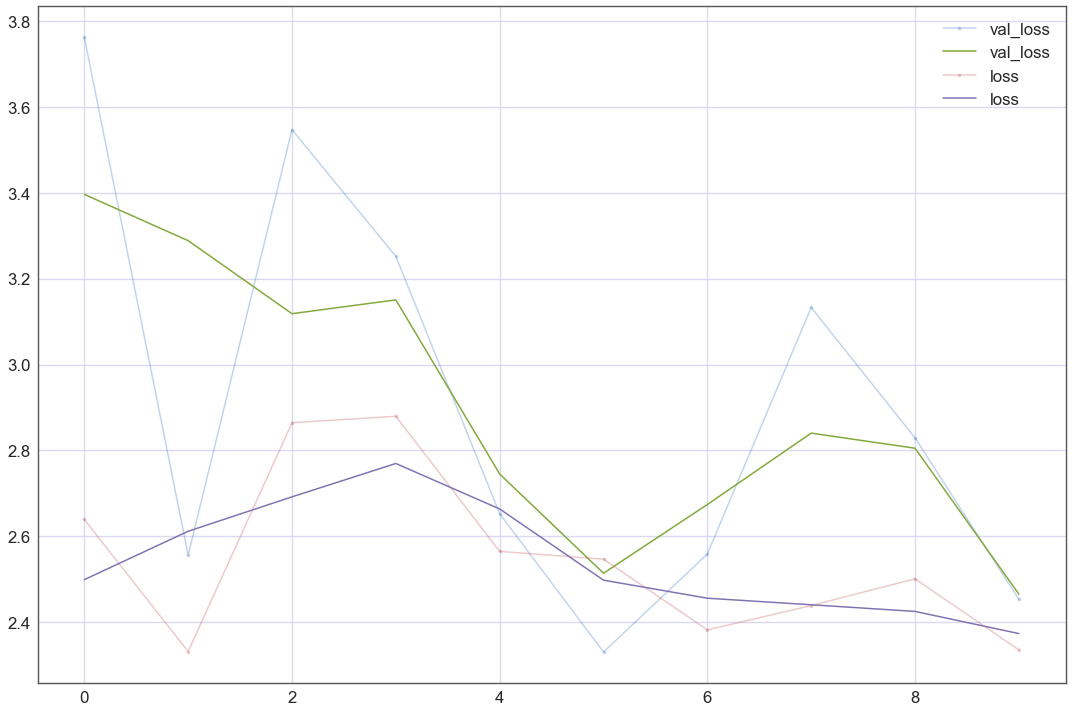

In [51]:
fit_model(4)

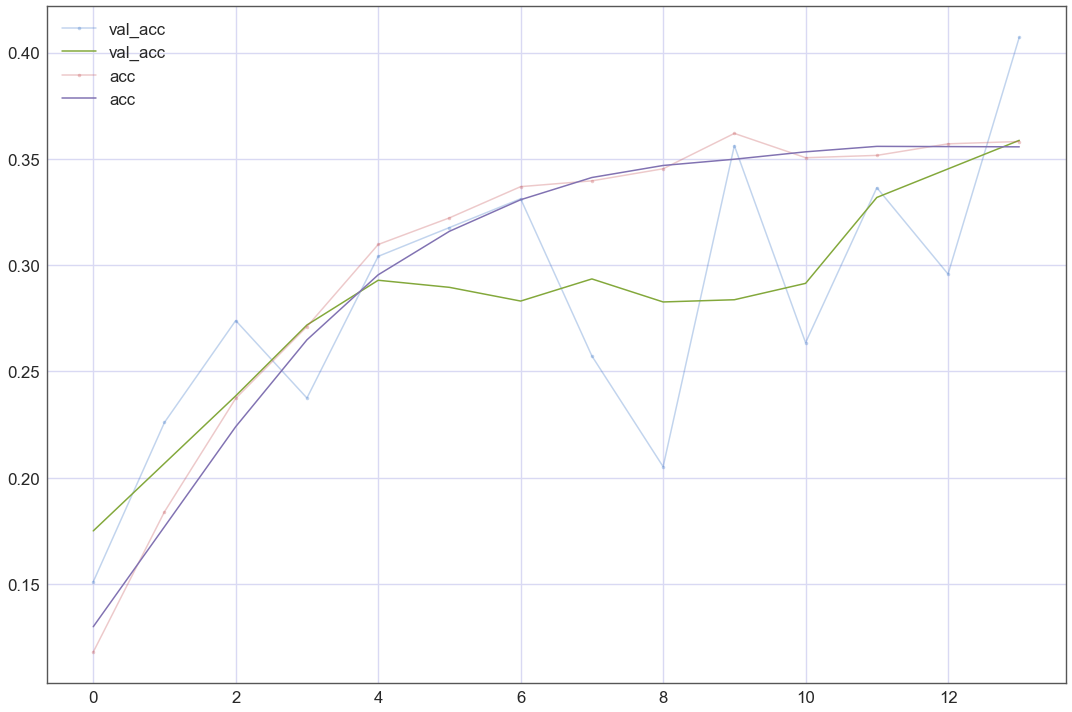

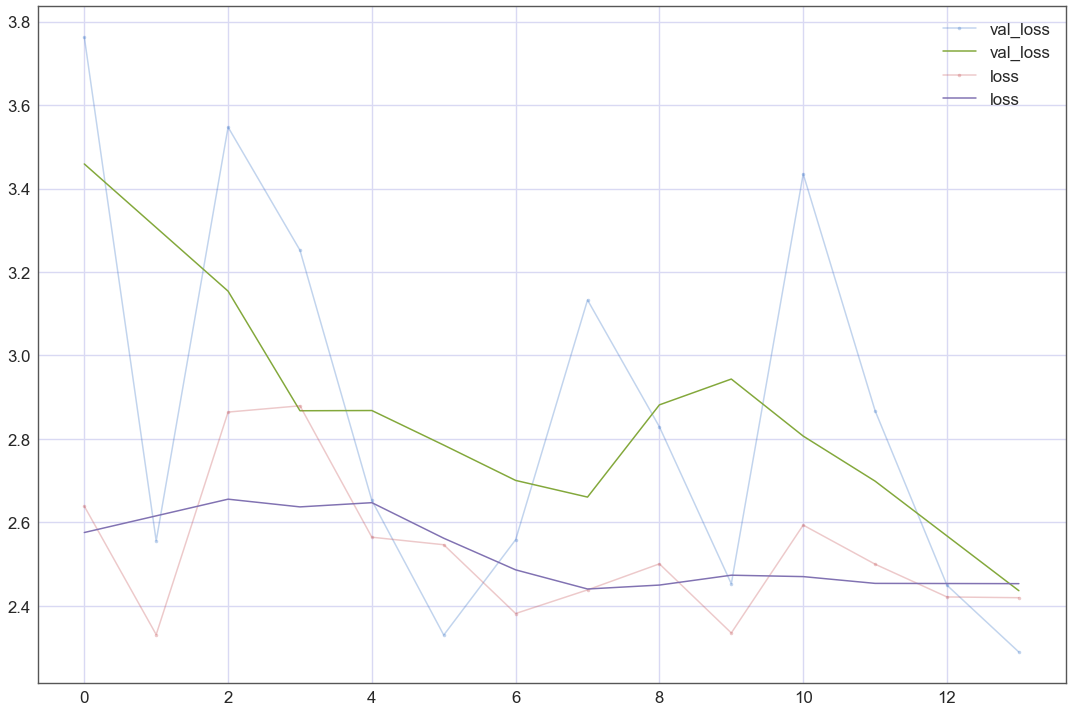

In [52]:
fit_model(4)

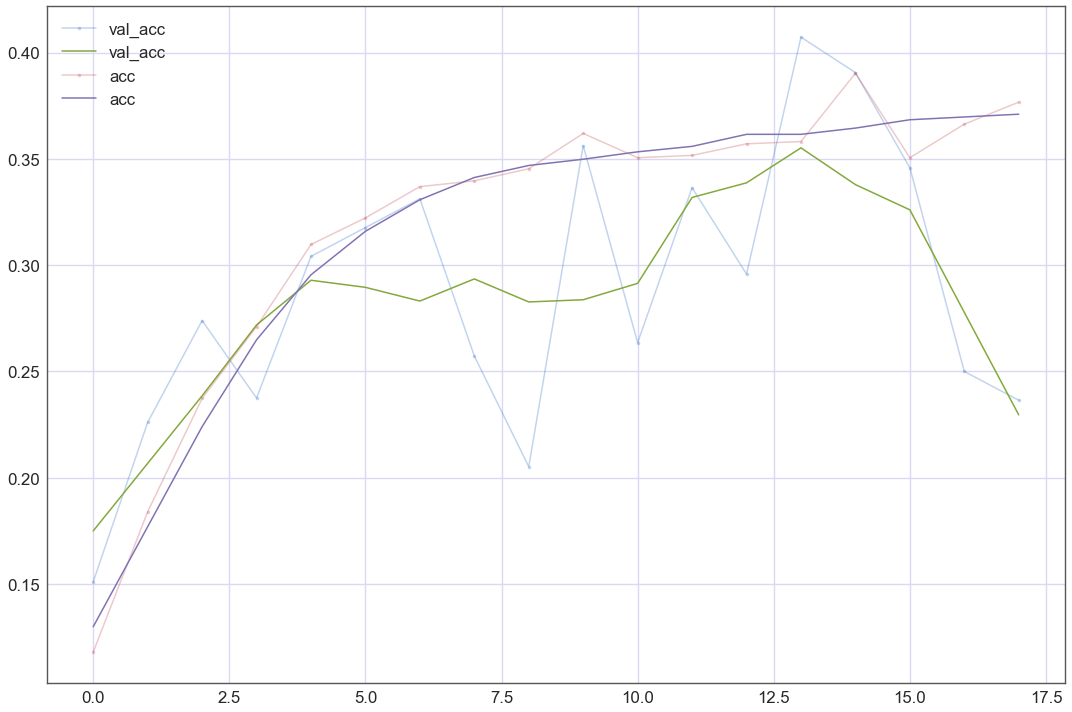

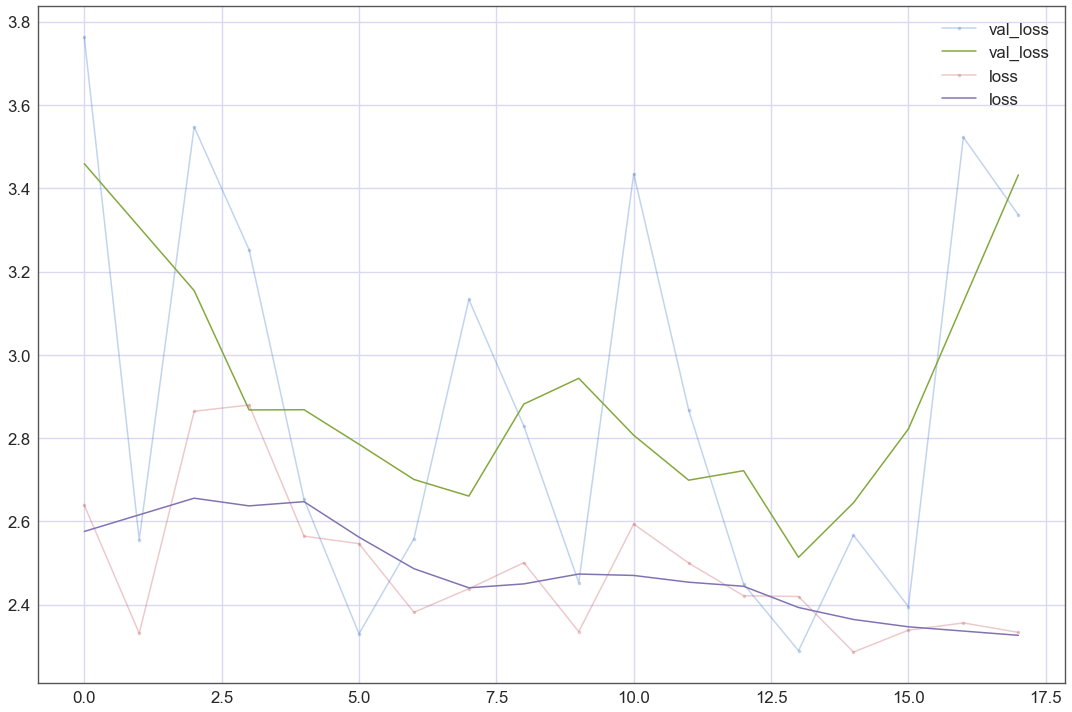

In [53]:
fit_model(4)

## Single Hidden Layer

In [54]:
def get_model():
    K.clear_session()

    model = Sequential([BatchNormalization(input_shape=(224, 224, 3)),
                        Flatten(),
                        Dense(100, activation='relu'),
                        BatchNormalization(),
                        Dense(10, activation='softmax')])

    model.name = 'Single-Hidden'
    model.history = {}
    model.compile('adam', 'categorical_crossentropy', ['accuracy'])

    return model


model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               15052900  
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 15,054,322
Trainable params: 15,054,116
Non-trainable params: 206
_________________________________________________________________


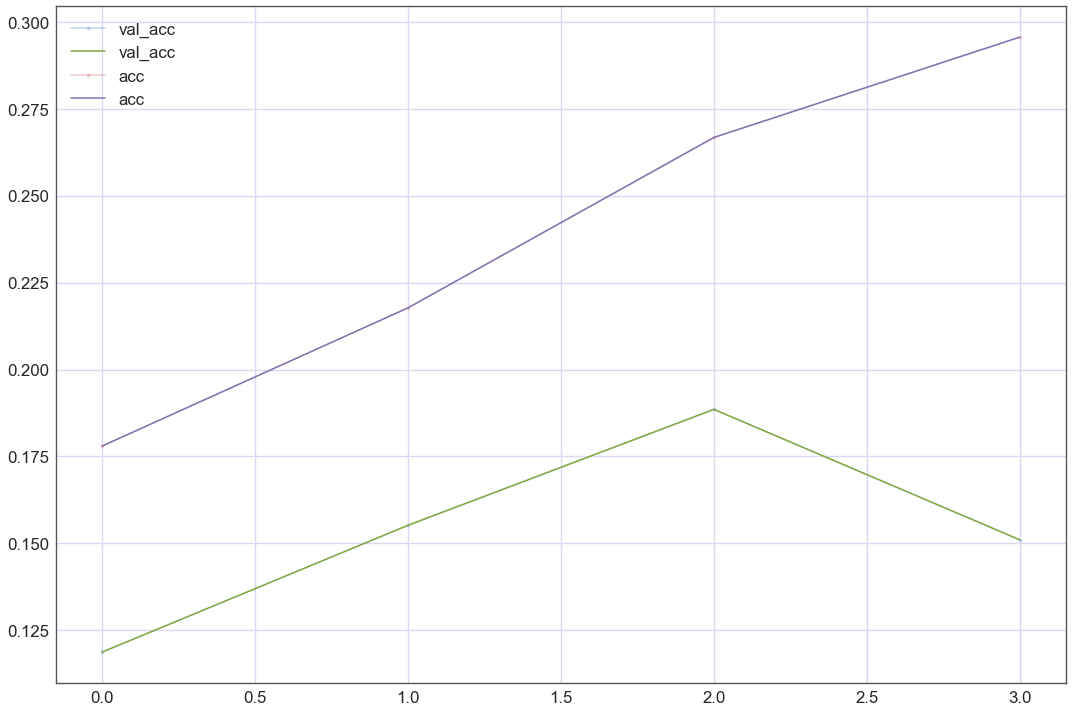

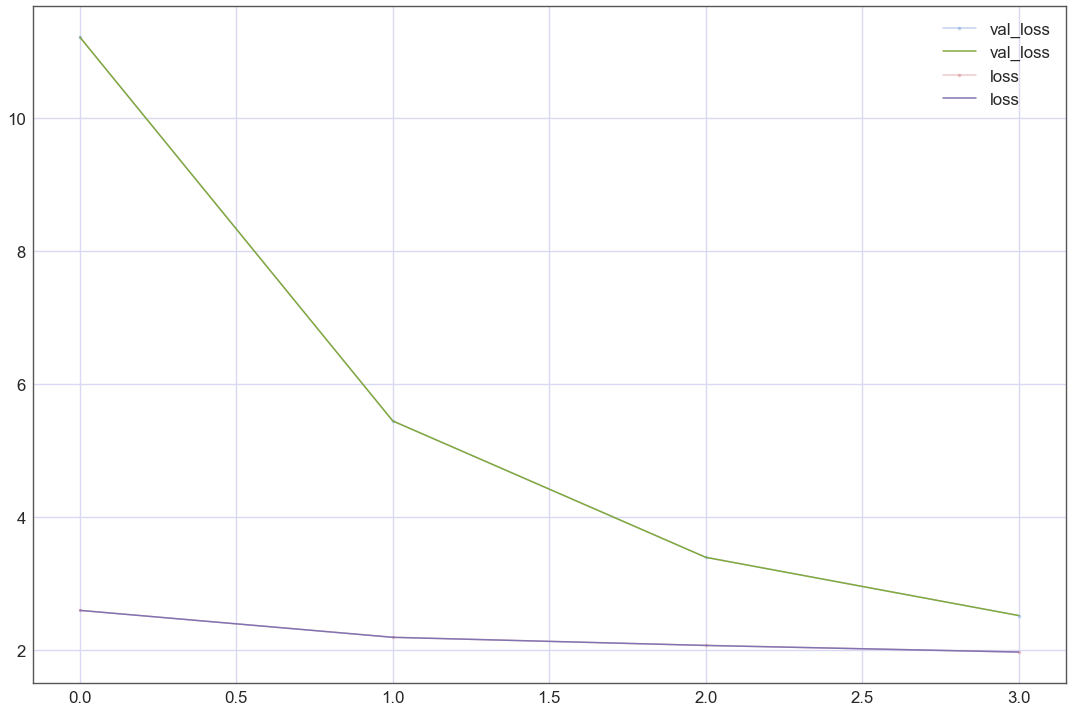

In [55]:
fit_model(4)

Not good! Lots of overfitting!

## ConvNet

In [16]:
def get_model():
    K.clear_session()

    model = Sequential([BatchNormalization(input_shape=(224, 224, 3)),
                        Conv2D(32, (3, 3), strides=(2, 2),
                               padding='same', activation='relu'),
                        BatchNormalization(),
                        Conv2D(64, (3, 3), strides=(2, 2),
                               padding='same', activation='relu'),
                        BatchNormalization(),
                        Flatten(),
                        Dense(100, activation='relu'),
                        BatchNormalization(),
                        Dense(10, activation='softmax')])

    model.name = 'ConvNet'
    model.history = {}
    model.compile('adam', 'categorical_crossentropy', ['accuracy'])
    return model


model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 56, 56, 64)        256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20070500  
__________

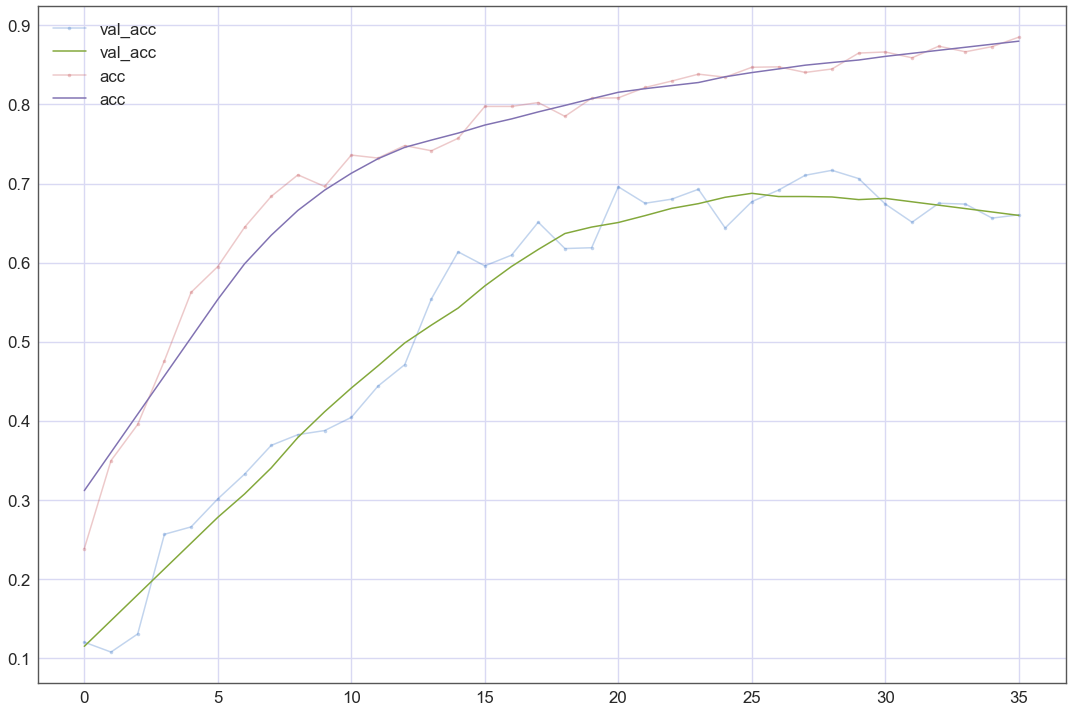

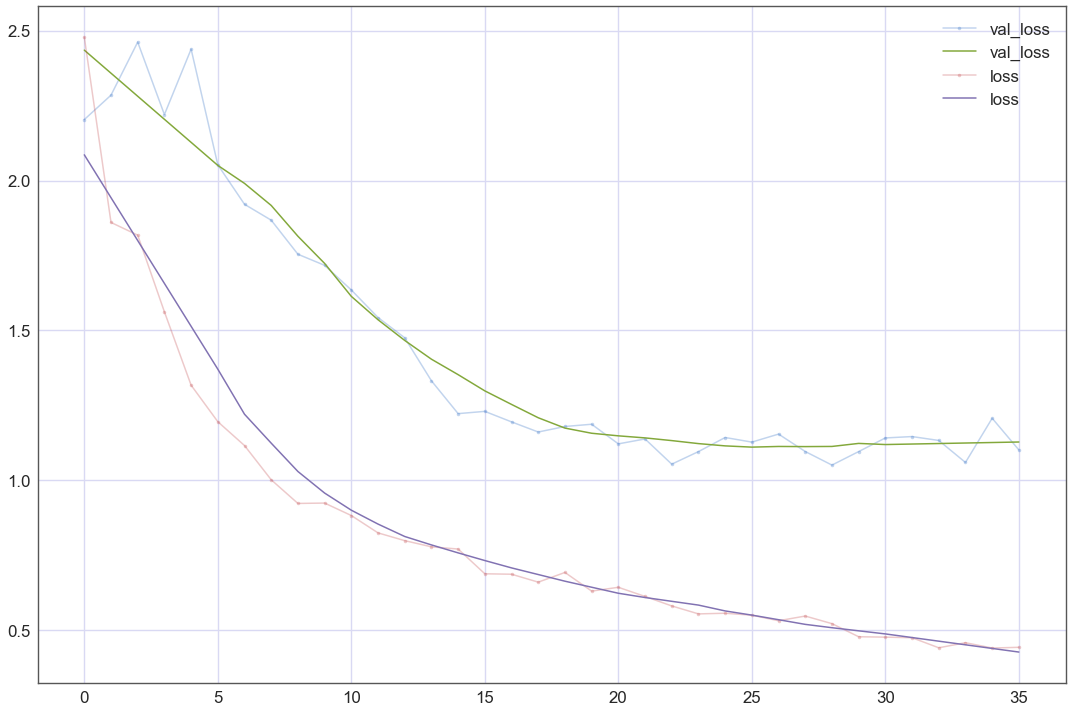

In [17]:
fit_model([2, 4, 30], [1e-4, 1e-3, 1e-4], save=True)

In [18]:
model=inflate_model('ConvNet')

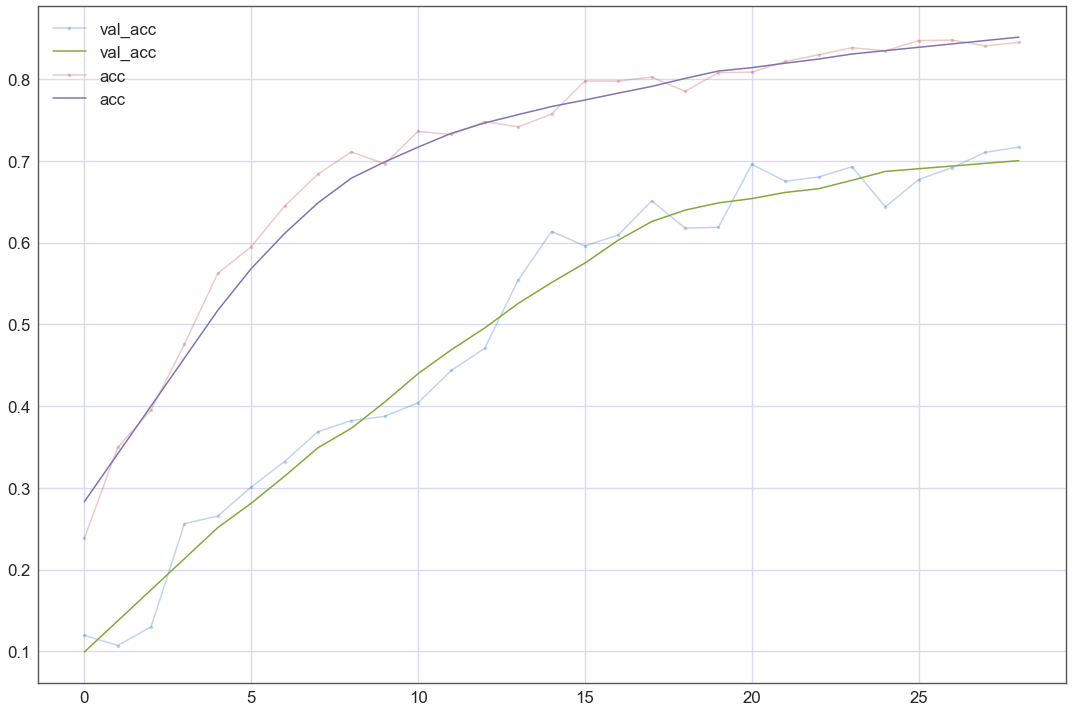

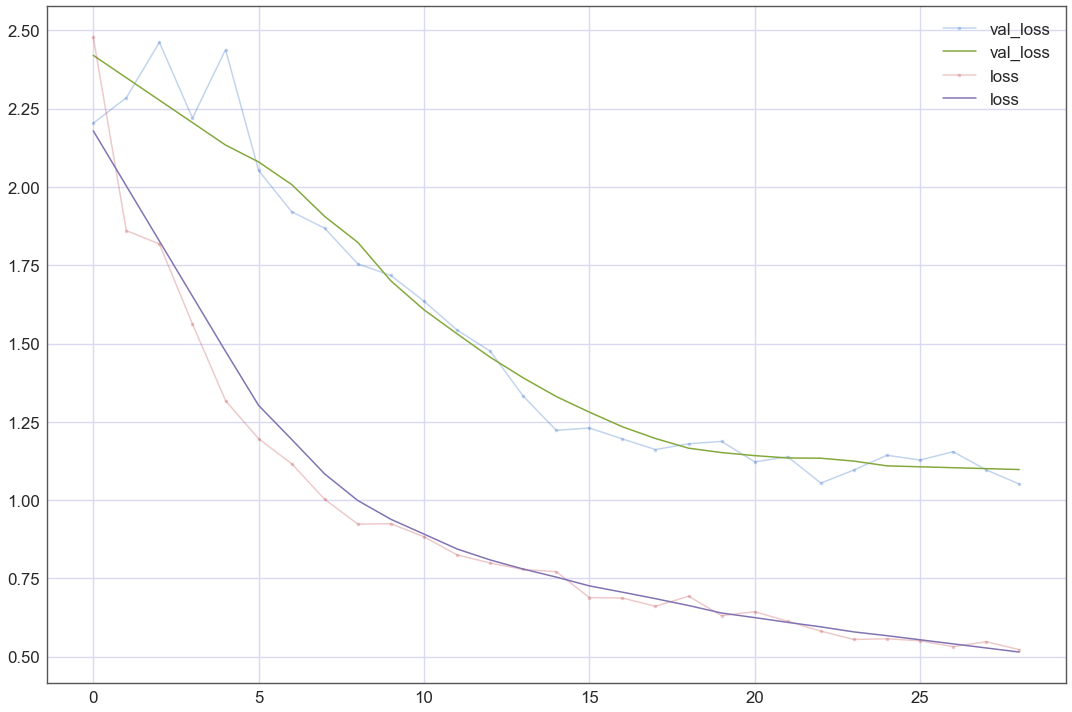

In [19]:
plot_history()

In [21]:
for k, v in dataset_consts(DIR_DATA, use_sample=False):
    exec(k+'=v')

In [22]:
valid_batches = get_batches(DIR_VALID, generator, 64, False)

Found 3363 images belonging to 10 classes.


In [23]:
model.evaluate_generator(valid_batches, valid_batches.num_batches)

[1.0297207843798857, 0.70703125]